#  Apple Stock Price Prediction By Deep Learning Models

Table of Content:
* Data importing
* EDA
* Modeling and Evaluations
* Discussion


By Vieno Wu, HongYe Zheng, Qi Yang


Github Link: https://github.com/venla9402/16B-Project

## Introduction

The financial markets are complex systems influenced by a multitude of factors, ranging from economic indicators to investor sentiment. Accurately predicting stock prices within such a dynamic environment remains one of the most challenging tasks in the realm of quantitative finance and data science. In this project, we are interested in predicting the closing prices of Apple stock, utilizing various machine learning models to explore their efficacy in capturing the intricate patterns inherent in stock market data.

## Motivation



As a group of students with backgrounds in financial mathematics and modeling, this project provides a unique opportunity to delve into the world of data science. Our focus is primarily on time series data, which is crucial to financial markets for predicting trends and making informed decisions. This exploration not only aligns with our academic pursuits but also resonates with our personal interests in financial analysis and modeling. From this project, we aim to enhance our understanding of data-driven decision-making processes and develop practical skills that are directly applicable to our future careers in finance and data science.

## Load Packages and Data

In [1]:
pip install --upgrade keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Load all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import tensorflow as tf
import keras
import math
import pmdarima as pm
from keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib import style
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, Hyperband,HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
from math import sqrt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## 1.Data

We obtain Apple Inc.'s 2014-2024 daily stock prices from the NASDAQ official website.

In [4]:
#Reading in the dataimport pandas as pd
data_url = 'https://raw.githubusercontent.com/venla9402/16B-Project/main/apple_stock_price_data.csv'

stock_data = pd.read_csv(data_url)
print(stock_data.head())

print(stock_data.shape)

     Date      Open       High        Low      Close    Adj Close   \
0  1/2/14  19.845715  19.893929  19.715000  19.754642    17.318729   
1  1/3/14  19.750000  19.775000  19.301071  19.320715    16.938305   
2  1/6/14  19.194643  19.530000  19.057142  19.426071    17.030676   
3  1/7/14  19.440001  19.498571  19.211430  19.287144    16.908880   
4  1/8/14  19.243214  19.484285  19.238930  19.409287    17.015959   

          Volume   
0  234,684,800.00  
1  392,467,600.00  
2  412,610,800.00  
3  317,209,200.00  
4  258,529,600.00  
(2596, 7)


Based on the result, there are 2596 rows and 7 columns

In [5]:
#Display column names
stock_data.columns

Index(['Date', ' Open ', ' High ', ' Low ', ' Close ', ' Adj Close ',
       ' Volume '],
      dtype='object')

We convert the 'Date" column to datetime for subsequent processing and modeling purposes.

In [6]:
stock_data['Date']= pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True) # Definition of the dataframe index as a Date column.
#column to string, replace commas, and then convert to float.
stock_data[' Volume '] = stock_data[' Volume '].astype(str).str.replace(',', '').astype(float)
stock_data.head()

C:\Users\65732\AppData\Local\Temp\ipykernel_4600\3912256136.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_data['Date']= pd.to_datetime(stock_data['Date'])


Open       High        Low      Close   Adj Close   \
Date                                                                 
2014-01-02  19.845715  19.893929  19.715000  19.754642   17.318729   
2014-01-03  19.750000  19.775000  19.301071  19.320715   16.938305   
2014-01-06  19.194643  19.530000  19.057142  19.426071   17.030676   
2014-01-07  19.440001  19.498571  19.211430  19.287144   16.908880   
2014-01-08  19.243214  19.484285  19.238930  19.409287   17.015959   

                Volume   
Date                     
2014-01-02  234684800.0  
2014-01-03  392467600.0  
2014-01-06  412610800.0  
2014-01-07  317209200.0  
2014-01-08  258529600.0

## 2. Exploratory Data Analysis (EDA)

We start by investigating basic characteristics and patterns of the raw dataset.

In [7]:
#summary statistics
summary_stats = stock_data.describe()
#print the summary statistics
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
              Open         High          Low        Close    Adj Close   \
count  2596.000000  2596.000000  2596.000000  2596.000000  2596.000000   
mean     80.967718    81.834711    80.150662    81.031764    79.149379   
std      58.005993    58.635983    57.416700    58.057518    58.619916   
min      17.684999    17.911785    17.626785    17.849285    15.650000   
25%      30.245625    30.506875    30.043750    30.287500    27.708725   
50%      50.060000    50.406250    49.625000    50.137499    48.339680   
75%     141.250004   143.152496   138.802502   141.522495   140.115948   
max     198.020000   199.620000   197.000000   198.110000   197.860000   

            Volume   
count  2.596000e+03  
mean   1.343229e+08  
std    8.383243e+07  
min    2.404834e+07  
25%    7.895815e+07  
50%    1.099346e+08  
75%    1.655673e+08  
max    1.065523e+09  


The summary statistics table includes key statistical measures for the Open, High, Low, Close, Adj Close, and Volume columns of Apple’s stock data

Count: The number of observations (days) in the dataset. For all price-related columns (Open, High, Low, Close, Adj Close), there are 2596 observations. The same count applies to the Volume column.

Mean: The average value of the observations. For example, the average closing price is approximately 81.03 USD.

Standard Deviation (std): A measure of the dispersion or variability in the data. For instance, the standard deviation of the closing price is approximately 58.06 USD, indicating significant variability in the stock price.

Minimum (min): The smallest observed value. The minimum closing price observed is 17.85 USD.

25% (First Quartile): The value below which 25% of the observations fall. For the closing price, 25% of the observations are below 30.29 USD.

50% (Median): The middle value of the observations, where half of the data points are below and half are above. The median closing price is 50.14 USD.

75% (Third Quartile): The value below which 75% of the observations fall. For the closing price, 75% of the observations are below 141.52 USD.

Maximum (max): The largest observed value. The maximum closing price is 198.11 USD.

The volume column statistics show the trading volume in terms of the number of shares traded: The average trading volume is approximately 134.32 million shares. The minimum volume recorded is approximately 2.40 million shares, and the maximum is around 1.065 billion shares.


In [8]:
#Check of missing values and display the cleaned data
missing_values = stock_data.isnull().sum()
missing_values, stock_data.head()

(Open          0
 High          0
 Low           0
 Close         0
 Adj Close     0
 Volume        0
 dtype: int64,
                 Open       High        Low      Close   Adj Close   \
 Date                                                                 
 2014-01-02  19.845715  19.893929  19.715000  19.754642   17.318729   
 2014-01-03  19.750000  19.775000  19.301071  19.320715   16.938305   
 2014-01-06  19.194643  19.530000  19.057142  19.426071   17.030676   
 2014-01-07  19.440001  19.498571  19.211430  19.287144   16.908880   
 2014-01-08  19.243214  19.484285  19.238930  19.409287   17.015959   
 
                 Volume   
 Date                     
 2014-01-02  234684800.0  
 2014-01-03  392467600.0  
 2014-01-06  412610800.0  
 2014-01-07  317209200.0  
 2014-01-08  258529600.0  )

The output of the code shows that there are no missing values in any of the columns (Open, High, Low, Close, Adj Close, and Volume), indicating that the dataset is ready for future work.

Description of each column in the dataset (Pretty Self Explanatory):

Date: This column represents the date of the trading day. It is set as the index of the DataFrame.

Open: The opening price of the stock on a given trading day. This is the price at which the first trade of the day occurred.

High: The highest price of the stock reached during the trading day.

Low: The lowest price of the stock reached during the trading day.

Close: The closing price of the stock on a given trading day. This is the price at which the last trade of the day occurred.

Adj Close: The adjusted closing price of the stock, which accounts for any corporate actions such as stock splits, dividends, and rights offerings. This gives a more accurate reflection of the stock's value.

Volume: The total number of shares traded during the trading day. This indicates the liquidity and trading activity of the stock.

Box Plots for Price Distribution:

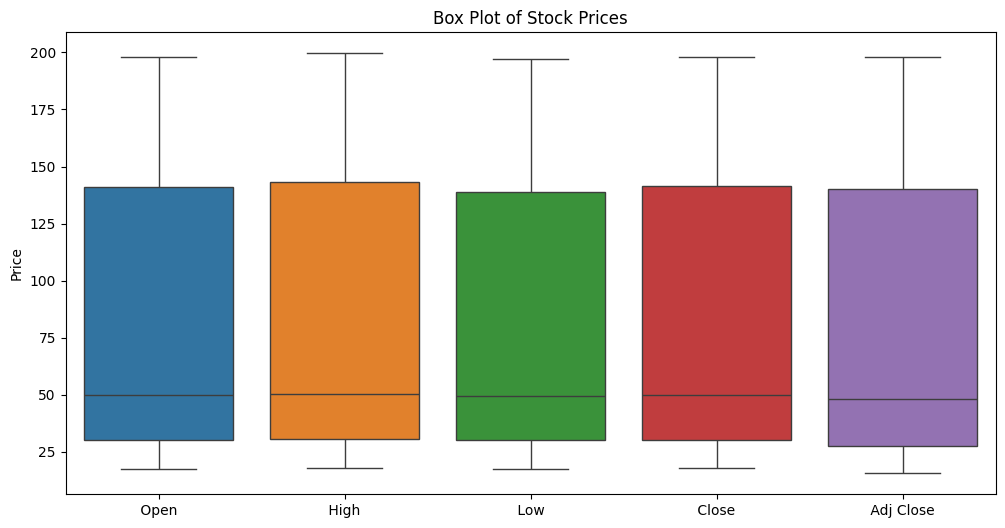

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=stock_data[[' Open ', ' High ', ' Low ', ' Close ', ' Adj Close ']])
plt.title('Box Plot of Stock Prices')
plt.ylabel('Price')
plt.show()

Based on the box plot, the median lines are relatively centered within the boxes for all price types (Open, High, Low, Close, Adj Close), indicating a balanced distribution of prices around the central value. The height of the boxes shows the variability in stock prices. The more spread out the box, the more variability there is in the stock prices. For example, the high and low prices have slightly more spread than the opening and closing prices, indicating more fluctuation in intraday trading. We do not see any extreme outliers, which means that there are no abnormal spikes or drops in the stock prices, indicating the stable price trend over the period.

#### Stock Price Chart 2014 - 2024

In [10]:
#Visualizing the price movement (open, high, low, close) of the stock over time.
#create a candlestick chart
fig = go.Figure(data=[go.Candlestick(
    #use the index for the x-axis (dates)
    x=stock_data.index,
    #stock open, high, low, close price
    open=stock_data[' Open '],
    high=stock_data[' High '],
    low=stock_data[' Low '],
    close=stock_data[' Close ']
)])

#update the layout of the figure to add titles and axes labels
fig.update_layout(title='Apple Stock Price Chart 2014-2024',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)',
                  xaxis_rangeslider_visible=False)

#display
fig.show()

To effectively visualize the price movement of Apple stock over time, including the open, high, low, and close prices, we created a candlestick chart. which is a type of chart that is particularly useful for showing the stock price movements within a specific time frame and can help identify trends and patterns. Based on the candlestick chart which displays the stock prices from 2014 to 2024. Each candlestick represents a single day's price movement, showing the open, high, low, and close prices. The green candlesticks indicate days when the closing price was higher than the opening price, whereas the red candlesticks indicate days when the closing price was lower than the opening price. This visualization helps to understand the volatility and overall trend of Apple's stock price over the given period.

#### Histogram of Daily Returns

In [11]:
#Histogram of Daily Returns
#compute daily returns (the percentage change from the previous day)
stock_data['Daily Return'] = stock_data[' Close '].pct_change()

#drop NA if any
stock_data = stock_data.dropna()

#create a histogram of daily returns
fig = go.Figure(data=[go.Histogram(x=stock_data['Daily Return'], nbinsx=50, marker_color='blue')])

#update the layout to add titles and axes labels
fig.update_layout(
    title='Histogram of Apple Stock Daily Returns',
    xaxis_title='Daily Return',
    yaxis_title='Frequency',
    template="plotly_white"
)

#display
fig.show()


The histogram of daily returns provides insights into the distribution of daily percentage changes in stock prices. This is useful for understanding the stock's volatility and the typical range of daily price movements.

Based on the histogram generated, it displays the frequency of daily returns for Apple’s stock over the specified period. The daily return is calculated as the percentage change from one day's closing price to the next. Most of the daily returns cluster around the mean, with fewer extreme values on either end, forming a bell-shaped distribution.

This plot helps to assess the stock’s volatility. A higher concentration of returns near zero indicates lower volatility, while wider distribution signifies higher volatility. The histogram also helps identify any skewness in the distribution. For instance, a long tail on the right would indicate occasional high positive returns, while a long tail on the left would suggest frequent significant losses.

Based on the histogram, it is centered around zero, suggests that on most days, the price changes are relatively small. The shape appears to be fairly symmetrical, indicative of a normal distribution, suggesting that the returns are influenced by many small, independent effects. The spread of the hisotgram is relatively moderate with a few outliers on both postive and negative sides. Also, the height of the bins around zero shows that most of the daily return are close to zero.

#### Box Plot of Daily Returns

In [12]:
#Create a box plot of daily returns
fig = go.Figure()
fig.add_trace(go.Box(y=stock_data['Daily Return'], boxpoints='all', jitter=0.3, pointpos=-1.8, marker_color='blue'))

#Update the layout to add titles and axes labels
fig.update_layout(
    title='Box Plot of Apple Stock Daily Returns',
    yaxis_title='Daily Return',
    template='plotly_white'
)

# Display the figure
fig.show()

A box plot provides a summary of the distribution of a dataset. The box plot of Apple stock's daily returns showcases the distribution of daily percentage changes in the stock price. The majority of daily returns are clustered around the median, with the interquartile range (box) showing where most data points lie. There are several outliers on both the positive and negative sides, indicating days with unusually high or low returns. The distribution of daily returns appears to be fairly symmetrical around the median, with a slight skew towards positive returns. From the boxplot, we can understand and identify the potential range of daily price movements.

#### Heatmap of Correlations

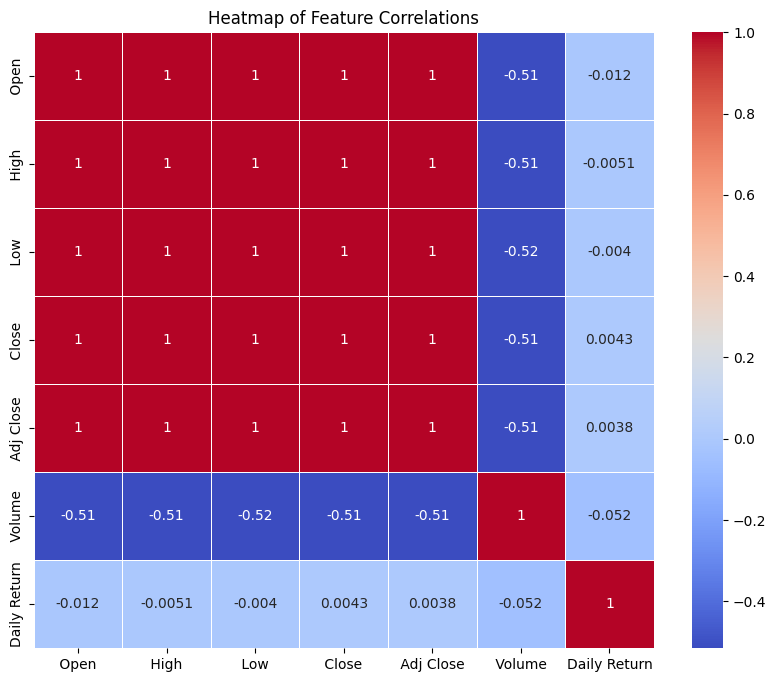

In [13]:
#Compute the the correlation matrix
corr_matrix = stock_data.corr()

#Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

Analyzing Feature Correlations with the Heatmap

In this heatmap, the diagonal elements are all 1, indicating that each feature is perfectly correlated with itself. Open, High, Low, Close, and Adj Close have very high positive correlations with each other (correlation coefficient close to 1), indicating that these price features move together. This also indicates a strong linear relationship among the predictor variables.

We also found that volume has a moderate negative correlation with the price features (Open, High, Low, Close, and Adj Close), suggesting that as volume increases, these price features tend to decrease slightly, though the relationship is not very strong.
Daily Return shows very low correlations with all other features, indicating that the daily return is relatively independent of the other variables. Based on the heatmap, we can see that column expect for volume and daily return has a extremely high correlations with each other. Furthermore, we have created 3 new columns of the moving average which also is highly correlated with all the other varaibles except for daily return and volume.


For our time series anaylsis, we define our target variable to be 'Close' column of Apple price data. We have seen that the open,high,low,close and adj close are strongly correlated, so making prediction of one of them will allow us to gain insights about the others. Closing price is the last price that the buyer is willing to pay and seller is willing to sell at, so it relects the collective opinion of the buyers and the sellers. Closing price also reveals how the the market thinks the stock is worth, therefore serving as a valuable reference in making trade decisions. \
To better understand closing price, we plot the Autocorrelation plot,Moving Averages plot, Closing price and volume plot, and MACD plot to visualize the trend and study the characteristics of closing price.

#### Autocorrelation Plot

<Figure size 1000x600 with 0 Axes>

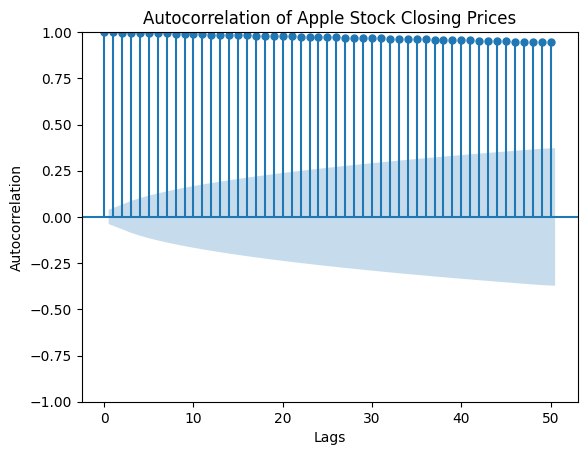

In [14]:
#Create an autocorrelation plot
plt.figure(figsize=(10, 6))
plot_acf(stock_data[' Close '], lags=50)
plt.title('Autocorrelation of Apple Stock Closing Prices')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

An autocorrelation plot is used to measure and visualize the correlation of a time series with its own lagged values. It helps identify repeating patterns or periodicity over time. The plot shows the correlation coefficients for different lags. The y-axis represents the autocorrelation coefficient, which ranges from -1 to 1, while the x-axis represents the number of lags. Each vertical var indicates the autocorrleation represents the number of lags. Each verticial bar indicates the autocorrelaton of the time series with itself at different lag values. We can see that at Lag 0: the autocorrelation is 1, as any series is perfectly correlated with itself. The bars at higher lags are also very close to 1, indicating that the stock's closing prices are highly correlated with their past values, even at longer lags. This suggests a strong persistence in the price movements, meaning that past prices have a significant influence on future prices. The blue shaded area represents the 95% confidence interval for the autocorrelation coefficients. If the bars fall outside this region, the autocorrelation is statistically significant. In this plot, almost all lags show significant autocorrelation. This pattern of high autocorrelation across many lags suggests that Apple's stock prices exhibit strong momentum and trend persistence. Furthermore, the plot also indicates that past values of the stock price can be highly infomrative for forecasting future prices, models like ARIMA (AutoRegressive Integrated Moving Average) would likely be effective in predicitng future stock prices.

#### Stock Price with Multiple Moving Average

In [15]:
#A moving average plot that highlights different scales of trends. Assess stock behaves to short-term, medium-term, and long-term averages,
#computing the moving average
stock_data['MA50'] = stock_data[' Close '].rolling(window=50).mean()  # 50 day moving average
stock_data['MA100'] = stock_data[' Close '].rolling(window=100).mean()  # 100 day moving average
stock_data['MA200'] = stock_data[' Close '].rolling(window=200).mean()  # 200 day moving average

fig = go.Figure()

#line for closing price
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[' Close '], mode='lines', name='Close', line=dict(color='blue')))

#line plot for moving average
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['MA50'], mode='lines', name='50-Day MA', line=dict(color='red', dash='dot')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['MA100'], mode='lines', name='100-Day MA', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['MA200'], mode='lines', name='200-Day MA', line=dict(color='purple', dash='dashdot')))

#update the layout of the figure to add titles and axes labels
fig.update_layout(
    title='Apple Stock Price with Multiple Moving Averages',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    xaxis_rangeslider_visible=True,
    legend_title="Legend",
    template="plotly_white"
)

#display
fig.show()

To analyze trends and patterns in stock prices over different time horizons, we can use moving averages. A moving average smooths out price data to identify the direction of the trend. By comparing different moving averages, we can assess the stock's behavior in the short-term, medium-term, and long-term. In this case, we've plotted the 50-day, 100-day, and 200-day moving averages along with the actual closing prices.

The plot shows Apple's stock prices from 2014 to 2024 with three different moving averages superimposed on the closing price. The 50-day moving average (dotted red line) represents short-term trends, smoothing out the daily fluctuations to reveal shorter-term trends. The 100-day moving average (dashed green line) highlights medium-term trends, providing a balance between short-term noise and long-term trends. The 200-day moving average (dash-dot purple line) captures long-term trends, filtering out short-term volatility to show the overall direction of the stock price over a longer period.

By examining these moving averages together, we can gain insights into how the stock behaves over different periods. For instance, when the shorter-term moving averages (50-day and 100-day) cross above the longer-term moving average (200-day), it could indicate a bullish trend. Conversely, when they cross below, it might signal a bearish trend. This visualization can help other make more informed decisions by understanding the stock's performance over multiple time horizons.

#### Stock Price and Volume Trend

In [16]:
#Volume and Price Trend Chart to visualize the relationship between stock close price movements and trading volume

#create a subplot
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.03, subplot_titles=('Price', 'Volume'),
                    row_width=[0.2, 0.7])

#add the closing price line plot
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[' Close '], name='Close Price', line=dict(color='blue')), row=1, col=1)

#add the volume bar plot
fig.add_trace(go.Bar(x=stock_data.index, y=stock_data[' Volume '], name='Volume', marker_color='red'), row=2, col=1)

#update the layout to add titles, x axis
fig.update_layout(
    title='Apple Stock Price and Volume Trend',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    showlegend=False,
    template="plotly_white"
)

#update y axis
fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1, type='log')

#display
fig.show()

Visualizing Volume and Price Trends:

Analyzing both the stock price and its trading volume together can provide deeper insights into the market behavior. This plot displays the relationship between Apple’s stock price and the trading volume, which can help in understanding the dynamics of price movements and investor activity.

The chart consists of two subplots arranged vertically. The upper subplot displays the closing price of Apple's stock over time, represented by a blue line. This provides a clear view of the stock's performance and price fluctuations from 2014 to 2024. The lower subplot shows the trading volume as red bars. The volume bars indicate the number of shares traded each day.

By comparing these two subplots, we can observe how changes in trading volume correspond to price movements. For instance, high trading volumes often occur during significant price changes, suggesting strong investor interest and potential market volatility. Conversely, low trading volumes may indicate less market activity and stability in stock prices. This dual-axis visualization is useful for identifying trends, market sentiment based on the volume spikes.

#### Stock Price and MACD Indicator Plot

In [17]:
#Moving Average Convergence Divergence plot, to show the relationship between two moving averages.
#The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.
#The result of that calculation is the MACD line. A signal line, which is the 9-period EMA of the MACD itself, is then plotted on top of the MACD line,
#which can function as a trigger for buy and sell signals.

#compute MACD and Signal Line indicators
#short term exponential moving average
ShortEMA = stock_data[' Close '].ewm(span=12, adjust=False).mean()

#long term exponential moving average
LongEMA = stock_data[' Close '].ewm(span=26, adjust=False).mean()

#compute the MACD line
MACD = ShortEMA - LongEMA

#compute the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

#create subplot layout
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.01, subplot_titles=('Price', 'MACD'))

#add price line plot
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[' Close '], name='Close Price', line=dict(color='blue')), row=1, col=1)

#add MACD line plot
fig.add_trace(go.Scatter(x=stock_data.index, y=MACD, name='MACD', line=dict(color='red')), row=2, col=1)

#add Signal line plot
fig.add_trace(go.Scatter(x=stock_data.index, y=signal, name='Signal Line', line=dict(color='green')), row=2, col=1)

#update the layout to add titles
fig.update_layout(
    title='Apple Stock Price and MACD Indicator',
    xaxis_title='Date',
    showlegend=False,
    template="plotly_white"
)

#update y axis
fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
fig.update_yaxes(title_text="MACD Value", row=2, col=1)

#display
fig.show()

The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a stock's price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. A signal line, which is the 9-period EMA of the MACD, is then plotted on top of the MACD line.

The plot consists of two subplots. The upper subplot displays the closing price of Apple’s stock from 2014 to 2024. The lower subplot shows the MACD line and the signal line. The MACD line (red) and the signal line (green) help in identifying bullish and bearish signals. When the MACD line crosses above the signal line, it is considered a bullish signal, suggesting it might be a good time to buy. Conversely, when the MACD line crosses below the signal line, it is considered a bearish signal, suggesting it might be a good time to sell.

By analyzing the MACD and its signal line, we can gain insights into the momentum of the stock price and make more informed trading decisions. The combination of these indicators provides a comprehensive view of both the price trend and the momentum, which can be crucial for timing entries and exits in the market.

## 3. Modeling


Before getting into each model, we first implement a Class called StockPricePlotter for plotting training data, testing data,and predictions, and training losses. We also implement a class called minmax for normalziation of data.

In [18]:
class StockPricePlotter:
    """
    A class to plot stock price data, including training, testing, and predicted data.

    Attributes:
    -----------
    stock_data : DataFrame
        A DataFrame containing stock data with a 'Close' column and DateTime index.
    train_size_ratio : float
        The ratio of the data to be used for training. Default is 0.8 (80% training, 20% testing).
    time_steps : int
        The number of time steps to use for predictions. Default is 60.

    Methods:
    --------
    plot_prices(train, test, y_pred_test):
        Plots training data, testing data, and predicted testing data on a single graph.
    plot_test_vs_prediction(test, y_pred_test):
        Plots testing data and predicted testing data on a single graph.
    plot_loss(history):
        Plots the training and validation loss over epochs.
    """

    def __init__(self, stock_data, model,train_size_ratio=0.8, time_steps=10,):
        """
        Constructs all the necessary attributes for the StockPricePlotter object.

        Parameters:
        -----------
        stock_data : DataFrame
            A DataFrame containing stock data with a 'Close' column and DateTime index.
        train_size_ratio : float, optional
            The ratio of the data to be used for training. Default is 0.8.
        time_steps : int, optional
            The number of time steps to use for predictions. Default is 60.
        model : string
            name of the current model
        """
        self.stock_data = stock_data
        self.train_size_ratio = train_size_ratio
        self.time_steps = time_steps
        self.train_size = int(len(stock_data) * self.train_size_ratio)
        self.model = model

    def plot_prices(self, train, test, y_pred_test):
        """
        Plots training data, testing data, and predicted testing data on a single graph.

        Parameters:
        -----------
        train : array-like
            The actual closing prices for the training data.
        test : array-like
            The actual closing prices for the testing data.
        y_pred_test : array-like
            The predicted closing prices for the testing data.
        """
        dates = self.stock_data.index
        train_dates = dates[:self.train_size]
        test_dates = dates[self.train_size:]

        plt.figure(figsize=(14, 7))


        # Plot training data
        plt.plot(train_dates[:len(train)], train, label='Training Actual', color='blue')

        # Plot test actual data
        plt.plot(test_dates[:len(test)], test, label='Testing Actual', color='green')

        # Plot predicted data (aligned with test timeline)
        test_pred_dates = test_dates[self.time_steps:len(y_pred_test) + self.time_steps]
        plt.plot(test_pred_dates, y_pred_test, label='Testing Predicted', color='red')

        plt.title(f'Actual vs Predicted Closing Prices {self.model}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()

    def plot_test_vs_prediction(self, test, y_pred_test):
        """
        Plots testing data and predicted testing data on a single graph.

        Parameters:
        -----------
        test : array-like
            The actual closing prices for the testing data.
        y_pred_test : array-like
            The predicted closing prices for the testing data.
        """
        test_dates = self.stock_data.index[self.train_size:]

        plt.figure(figsize=(14, 7))

        # Plot test actual data
        plt.plot(test_dates[:len(test)], test, label='Testing Actual', color='green')

        # Plot predicted data (aligned with test timeline)
        test_pred_dates = test_dates[self.time_steps:len(y_pred_test) + self.time_steps]
        plt.plot(test_pred_dates, y_pred_test, label='Testing Predicted', color='red')

        plt.title(f'Actual vs Predicted Closing Prices {self.model}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()

        ''' def plot_loss(self, history):
        """
        Plots the training and validation loss over epochs.

        Parameters:
        -----------
        history : History object
            The history object returned from model training, which contains the loss and validation loss for each epoch.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss{self.model}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.show()'''


    def plot_loss(self, history):
        """
        Plots the training and validation loss over epochs, including both the full range and the later half of the epochs.

        Parameters:
        -----------
        history : History object
            The history object returned from model training, which contains the loss and validation loss for each epoch.
        """
        # Calculate the starting epoch for the later half
        start_epoch = len(history.history['loss']) // 2

        # Extract the loss and validation loss for the full range
        full_training_loss = history.history['loss']
        full_validation_loss = history.history['val_loss']

        # Extract the loss and validation loss for the later half
        half_training_loss = full_training_loss[start_epoch:]
        half_validation_loss = full_validation_loss[start_epoch:]

        # Create subplots
        fig, axs = plt.subplots(2, 1, figsize=(12, 12))

        # Plotting the full loss
        axs[0].plot(full_training_loss, label='Training Loss')
        axs[0].plot(full_validation_loss, label='Validation Loss')
        axs[0].set_title(f'Model Loss (Full Epochs) - {self.model}')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend(loc='upper right')

        # Plotting the later half loss
        axs[1].plot(range(start_epoch, len(full_training_loss)), half_training_loss, label='Training Loss')
        axs[1].plot(range(start_epoch, len(full_validation_loss)), half_validation_loss, label='Validation Loss')
        axs[1].set_title(f'Model Loss (Later Half of Epochs) - {self.model}')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend(loc='upper right')
        plt.tight_layout()

In [19]:
## define a class for normalization
class minmax():

    """
    minmax is a class of minmax normalizers.
    Each normalizer has two instance attributes called min_val and max_val with default values 0 and 1, respectively.
    They will be updated in fit_transform command.
    """

    def __init__(self, min_val=0, max_val=1):

        self.min_val = 0
        self.max_val = 1

    def fit_transform(self,X):

        """
        X is supposed to be a 1D numpy array or 2D numpy array with only one row or one column.
        This function returns normalized X which has the same shape of X.
        The minimum value of X and the maximum value of X will replace self.min_val and self.max_val.
        """

        self.min_val = np.min(X)
        self.max_val = np.max(X)

        return (X - self.min_val) / (self.max_val - self.min_val)

    def transform(self, X):
        """
        X is supposed to be a 1D numpy array or 2D numpy array with only one row or one column.
        This function returns normalized X which has the same shape of X.
        """
        return (X - self.min_val) / (self.max_val - self.min_val)

    def inverse_transform(self, X_scaled):

        """
        X is supposed to be a 1D numpy array or 2D numpy array with only one row or one column.
        This function takes normalized data as input and transforms it back to original scale.
        The output has the same shape of X.
        """

        return X_scaled * (self.max_val - self.min_val) + self.min_val


### 3.1 Neural Network

Time series prediction involves forecasting future values based on previously observed values. We will first attempt a feedfoward neural network model to predict the closing prices of the stock. Neural network model can also handle  multicollinearity  as neural networks can have multiple layers and neurons that enable them to learn complex, non-linear relationships between the variables.

We start by preparing our dataset, focusing on the closing prices of the stock. The goal is to create a time series dataset that can be used to train and test various neural network models, including Feedforward Neural Networks (NN), Convolutional Neural Networks (CNN), and Gated Recurrent Units (GRU).

In [20]:
# Train Test Split
split_point = int(len(stock_data[' Close ']) * 0.8)
train, test = stock_data[' Close '][:split_point], stock_data[' Close '] [split_point:]

We then extract the closing prices of the stock and reshaped into a 2D array, then normalize it using the MinMaxScaler to scale the data between 0 and 1, which will ensure the data is within a consistent range and helps in faster convergence during training.


In [21]:
scaler = minmax()

#Reshape train dataset to 2D for scaling
train = np.reshape(train, (-1,1))

#Scaling train dataset
scaled_train = scaler.fit_transform(train)

#Reshape test dataset to 2D for scalings
test = np.reshape(test, (-1,1))

#Transform the Test dataset
scaled_test = scaler.transform(test)

We used a look-back period (or time_step), meaning that the model will use the closing prices of the previous number of days to predict the closing price of the next day. This involved creating sequences of number of days of closing prices as input features (X) and the corresponding next day's closing price as the target (Y).

In [22]:
#Create the training and testing data
time_step = 5
X_train, Y_train, X_test, Y_test = [], [], [], []

# Prepare training data
for i in range(time_step, len(scaled_train)):
    X_train.append(scaled_train[i-time_step:i, 0])
    Y_train.append(scaled_train[i, 0])

# Prepare testing data
for i in range(time_step, len(scaled_test)):
    X_test.append(scaled_test[i-time_step:i, 0])
    Y_test.append(scaled_test[i, 0])

X_train_nn, Y_train_nn = np.array(X_train), np.array(Y_train)
X_test_nn, Y_test_nn = np.array(X_test), np.array(Y_test)

We will then built a feedfoward nerual network model using the Keras Seuqential API. We define the input layer with 128 neurons, and ReLU activation function, the input dimension was set to time_step(10 in this case) which means that the model takes in 10 days of stock prices as input. We also added a drouput layer with droupout rate of 0.2 to prevent overfitting. In the two hidden layers, which has 64 and 32 neurons each using the ReLU activation function. The optimizer we use here is the Adam optimizer for efficient training, we also used the mean_squared_error as the loss function to measure the error between the predicted and actual values.

In [23]:
#Build the feedforward neural network model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_history=model.fit(X_train_nn, Y_train_nn, epochs=50, batch_size=32, validation_data=(X_test_nn, Y_test_nn),verbose = 1)

# Make predictions for the test dataset
test_predict = model.predict(X_test_nn)

# Inverse transform the predictions
test_predict = scaler.inverse_transform(test_predict)
Y_test_nn = scaler.inverse_transform(Y_test_nn.reshape(-1, 1))

#Calculate MSE
mse = mean_squared_error(Y_test_nn, test_predict)
print(f'Mean Squared Error: {mse}')

Epoch 1/50


C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0326 - val_loss: 7.5732e-04
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7627e-04 - val_loss: 0.0073
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 8.8195e-04 - val_loss: 0.0064
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 5.9413e-04 - val_loss: 0.0066
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 7.6188e-04 - val_loss: 0.0071
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 4.6063e-04 - val_loss: 0.0113
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 5.0285e-04 - val_loss: 0.0120
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 4.0829e-04 - val_loss: 0.0127
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 4.8815e-04 - val_loss: 0.0096
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 3.9328e-04 - val_loss: 0.0163
Epoch 12/50
65/65 ━━━━━━━━━━━

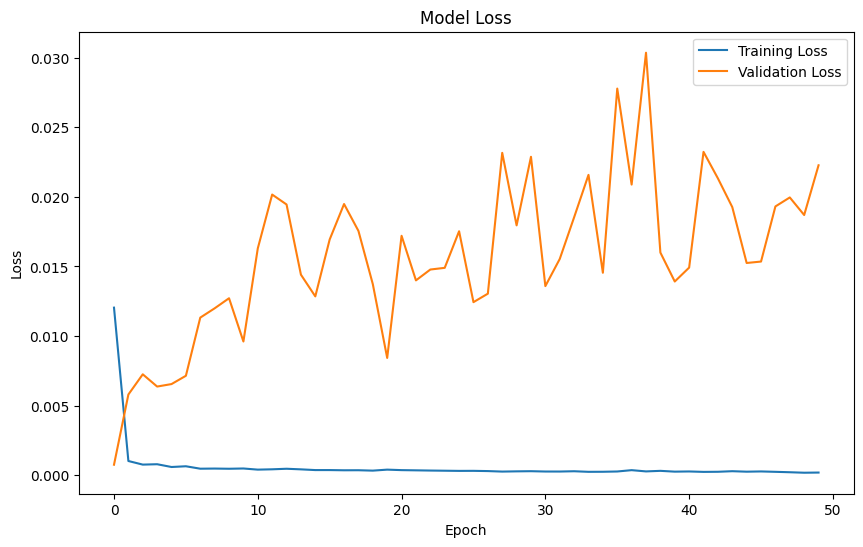

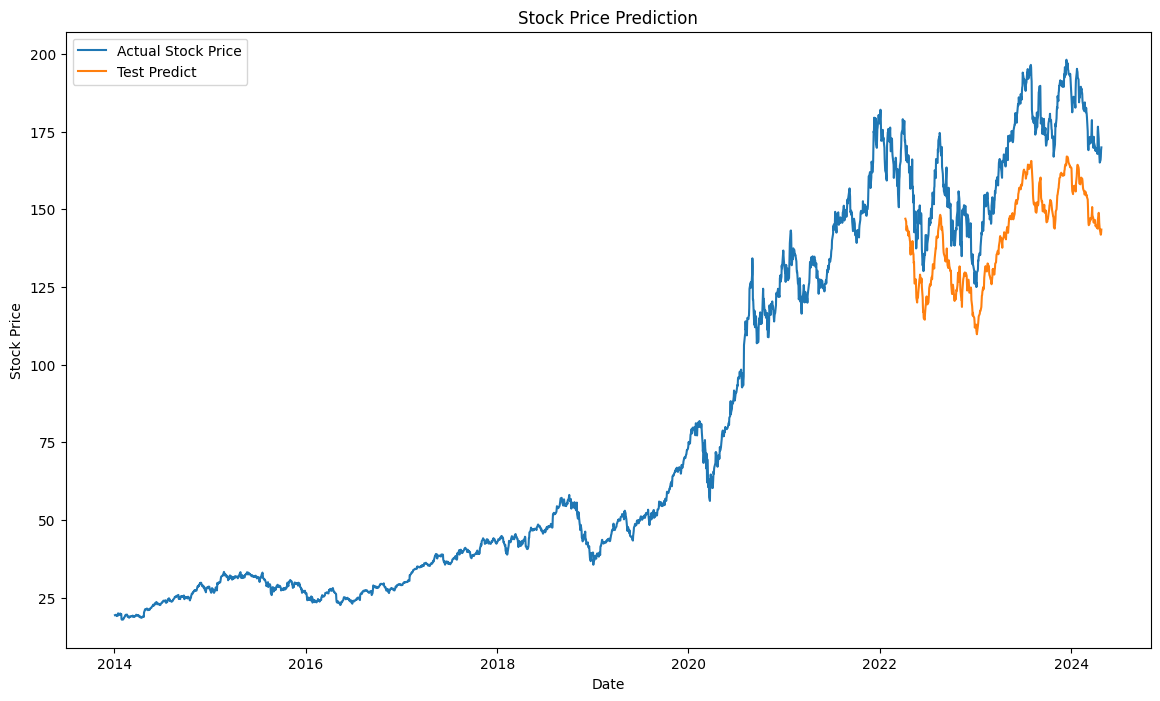

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(nn_history.history['loss'], label='Training Loss')
plt.plot(nn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Create a DataFrame for plotting
predictions = pd.DataFrame(index=stock_data.index[split_point + time_step:], data=test_predict, columns=['Test Predict'])
actual_prices = pd.DataFrame(index=stock_data.index, data=stock_data[' Close '].values, columns=['Actual Stock Price'])

# Plot the results
plt.figure(figsize=(14, 8))

# Plot actual stock prices
plt.plot(actual_prices.index, actual_prices['Actual Stock Price'], label='Actual Stock Price')

# Plot testing predictions
plt.plot(predictions.index, predictions['Test Predict'], label='Test Predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.show()
plt.tight_layout()

The results of our feedforward neural network model for the predicition shows a signficant difference between the training and validation loss. The training loss remained consistently low throught the epochs, whereas the validation loss exhibited condierable fluctations and remained substantially higher than the training loss. This suggests that while the model learned the patterns in the training data effectively, it struggled to generalize well to unseen data.

The Mean Squared Error (MSE) for the test predictions was fairly high, which reflects the a quite huge average squared difference between the actual and predicted stock prices. The plot of actual vs. predicted stock prices further illustrates the model's performance. Although the predicted prices follow the general trend of the actual stock prices, there are notable deviations, especially in areas with high volatility.
Furthermore, we realize that the predicted stock price always undershoot(lower than the acutal stock prices) which could be an indication that the current feedforward neural network architecture might not be complex enough to capture the intricate patterns and volatility in stock prices. Overall, the feedforward neural network model we attempted did not demonstrate a good preditive capability.

Based on the results of the previous model and relatively high value of MSE, we have decided to increase the complexity of the feedforwarrd neural network model. We decided to use the Kera's tuner to search for the best possible hyperparameters. Based on the loss history plot, we do see sign of overfitting occuring and decided to implement early stopping and see if we can fix the issue.

In [25]:
X_train_nn_l2, Y_train_nn_l2 = np.array(X_train), np.array(Y_train)
X_test_nn_l2, Y_test_nn_l2 = np.array(X_test), np.array(Y_test)

class NNHyperModel(HyperModel):
    '''
    A class to build a hyperparameter-tunable neural network model.

    Methods:
    build(hp): Builds and compiles the neural network model with hyperparameters by Keras Tuner.
    '''
    def build(self, hp):
        '''
        Build the neural network model.

        Parameters:
        hp : HyperParameters
            HyperParameters instance from Keras Tuner to specify hyperparameters.

        Returns
        model : Sequential
            Compiled Keras Sequential model.
        '''

        #Building the model layers with the range of hyperparameters
        model = Sequential()
        model.add(Dense(
            units=hp.Int('units1', min_value=128, max_value=512, step=32),
            activation='relu',
            input_dim=time_step,
            kernel_regularizer=l2(hp.Float('l2_1', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(
            units=hp.Int('units2', min_value=64, max_value=256, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_2', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(
            units=hp.Int('units3', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_3', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(
            units=hp.Int('units4', min_value=16, max_value=64, step=16),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_4', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dense(1))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate',min_value=1e-4, max_value=1e-2, sampling = 'LOG')),
                      loss = 'mean_squared_error', metrics =['mse'])
        return model


#Initialize the tuner for hyperparameter search using RandomSearch
tuner = RandomSearch(
    NNHyperModel(),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='nn tuning'
)

#set up early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#run the hyperparameter search with early stopping
tuner.search(X_train_nn_l2, Y_train_nn_l2, epochs=100, validation_data=(X_test_nn_l2, Y_test_nn_l2), batch_size=32, callbacks=[early_stopping])

#get the best hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#complie the model and train
model_regularization = tuner.hypermodel.build(best_hps)
nn_reg_history = model_regularization.fit(X_train_nn_l2, Y_train_nn_l2, epochs=100, batch_size=32, validation_data=(X_test_nn_l2, Y_test_nn_l2),verbose=1)

#make predictions for the test dataset
test_predict = model_regularization.predict(X_test_nn_l2)

#inverse transform the predictions
test_predict = scaler.inverse_transform(test_predict)
Y_test_nn_l2 = scaler.inverse_transform(Y_test_nn_l2.reshape(-1, 1))

#compute the MSE
test_mse_nn = mean_squared_error(Y_test_nn_l2, test_predict)
print(f'NN- Testing MSE: {test_mse_nn}')

Reloading Tuner from hyperparam_tuning\nn tuning\tuner0.json
Epoch 1/100


C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2465 - mse: 0.0398 - val_loss: 0.2093 - val_mse: 0.0288
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1782 - mse: 0.0056 - val_loss: 0.1863 - val_mse: 0.0355
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1493 - mse: 0.0048 - val_loss: 0.1532 - val_mse: 0.0261
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1266 - mse: 0.0045 - val_loss: 0.1384 - val_mse: 0.0302
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1073 - mse: 0.0032 - val_loss: 0.1178 - val_mse: 0.0249
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0936 - mse: 0.0039 - val_loss: 0.1150 - val_mse: 0.0345
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0809 - mse: 0.0030 - val_loss: 0.0911 - val_mse: 0.0208
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0707 - mse: 0.0025 - val_loss: 0.0848 - val_mse: 0.0228
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0625 - mse: 0.0

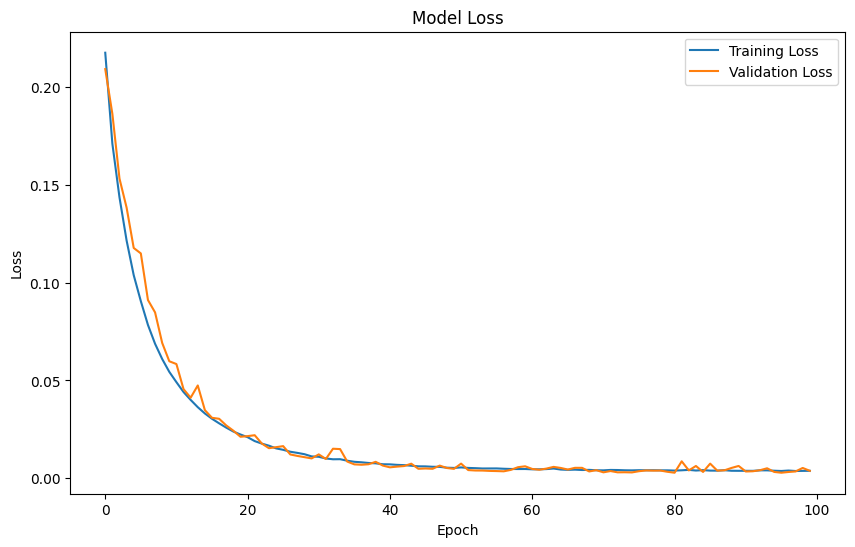

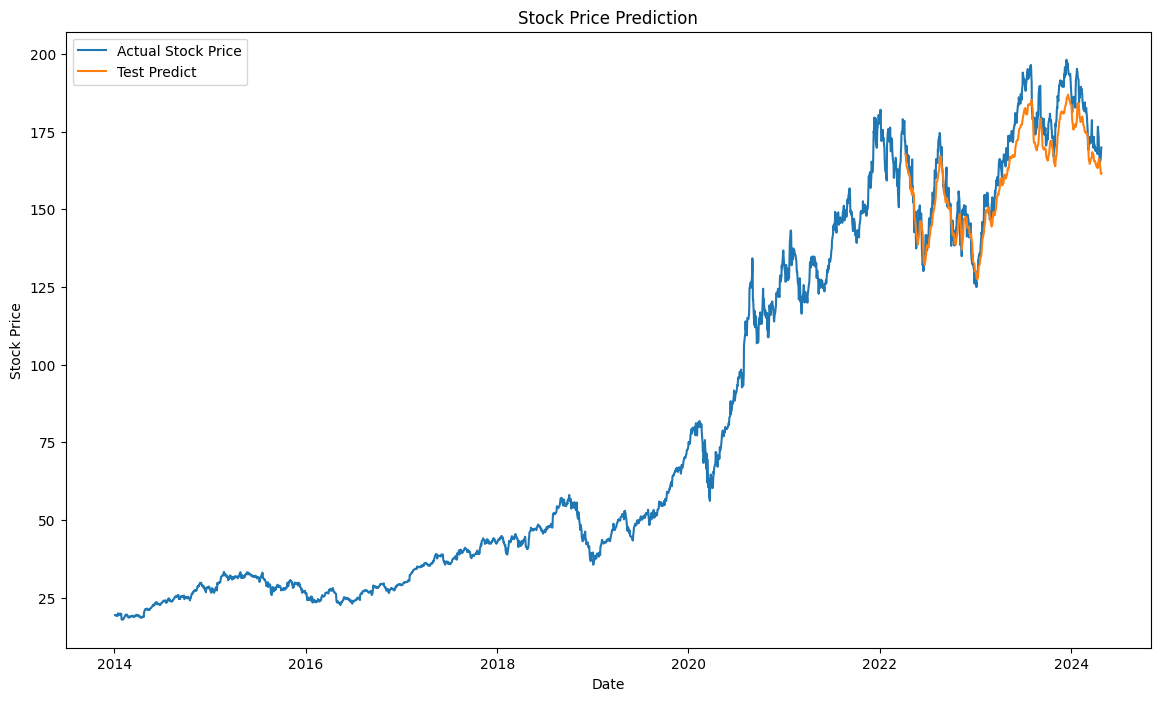

In [26]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(nn_reg_history.history['loss'], label='Training Loss')
plt.plot(nn_reg_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#Plot the predictions
predictions = pd.DataFrame(index=stock_data.index[split_point + time_step:], data=test_predict, columns=['Test Predict'])
actual_prices = pd.DataFrame(index=stock_data.index, data=stock_data[' Close '].values, columns=['Actual Stock Price'])
plt.figure(figsize=(14, 8))
plt.plot(actual_prices.index, actual_prices['Actual Stock Price'], label='Actual Stock Price')
plt.plot(predictions.index, predictions['Test Predict'], label='Test Predict')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.show()

After implementing a feedforward neural network model with tuning the hyperparameters, we do see a significant improvment in the model's performance. We see a much lower of MSE, indicating that the model begins to fit the training data well, learning the underlying patterns effectively. The improved metrics suggest that the model is now better at capturing the relevant patterns in the data without fitting too closely to the noise in the training set. Also, from the history plot of the loss over epoches, we do not see the issue of overfitting.

Before that, let us redo the train_test_split because we want to use only the Close Price column to predict future Close prices. We will do time series analysis using CNN,GRU,LSTM, and lastly ARIMA.

We also created a function named create_dataset designed to transofmr a one-dimensional time series data (like the closing prices of a stock) into a format suitable for training machine learning, particularly for sequence prediction.

In [27]:
def create_dataset(data, time_steps = 5):
    '''
    Reshape the dataset into windows of specified time steps for model input.

    Args:
        data (array-like): The closing prices.
        time_steps (int): The number of time steps to include in each window.
    Returns:
        tuple: Two arrays, the reshaped input features and corresponding targets.
    '''
    Xs, ys = [], []
    for i in range(time_steps, len(data)):
        Xs.append(data[i-time_steps:i,0])
        ys.append(data[i,0])
    return Xs, ys

### 3.2 CNN

Although Convolutional Neural Networks are commonly used in image processing, they also work in time series analysis due to their ability to capture local patterns. Before building the model, we will first preprocess the data for CNN using the function defined previously. For stock price prediction, CNNs can effectively identify trends and patterns by applying convolutional filters to the data. First, the input layer will accept the standardized feature set, which must be reshaped into a format suitable for CNNs. In this case, we use the past 5 days of data to predict the next day's closing price, creating a window of 5 time steps. The first convolutional layer applies the number of filters selected by the tuner with a corresponding kernel size selected by the tuner, which helps to learn local patterns in the time series data. The activation function introduces non-linearity to capture complex patterns. A max-pooling layer follows, reducing the dimensionality and retaining the most important features learned by the convolutional layer.


Next, the flatten layer converts the 2D matrix from the convolutional layers into a 1D vector, preparing it for the dense layers. The first dense layer consists of number of neurons with ReLU activation, further processing the flattened features. The output layer has a single neuron with a linear activation function, which is appropriate for predicting continuous values like the closing price. The model is compiled using the Adam optimizer, known for its efficiency and robustness, and the mean squared error (MSE) loss function, which is suitable for regression tasks. The model is trained for 100 epochs with a batch size of 32.

In [28]:
#Pre-processing for CNN
X_train_cnn, y_train_cnn = create_dataset(scaled_train, time_steps = 5)
X_test_cnn, y_test_cnn = create_dataset(scaled_test, time_steps = 5)

#Convert the data to numpy array
X_train_cnn, y_train_cnn = np.array(X_train_cnn), np.array(y_train_cnn)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1],1))
y_train_cnn = y_train_cnn.reshape((y_train_cnn.shape[0],1))
print(X_train_cnn.shape, y_train_cnn.shape)

#Convert the data to numpy array
X_test_cnn, y_test_cnn = np.array(X_test_cnn), np.array(y_test_cnn)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1],1))
y_test_cnn = y_test_cnn.reshape((y_test_cnn.shape[0],1))
print(X_test_cnn.shape, y_test_cnn.shape)

(2071, 5, 1) (2071, 1)
(514, 5, 1) (514, 1)


In [29]:
# Build the CNN model
time_steps = 5
class CNNHyperModelCNN(HyperModel):
    '''
    A class to build a hyperparameter-tunable CNN model.

    Methods
    build:
        Builds and compiles the CNN model with hyperparameters specified by Keras Tuner.
    '''

    def build(self, hp):
        '''
        Build the CNN model.

        Parameters
        hp : HyperParameters
            HyperParameters instance from Keras Tuner to specify hyperparameters.

        Returns
        model : Sequential
            Compiled Keras Sequential model.
        '''

        #model layers with the range of hyperparameters
        model = Sequential()
        model.add(Conv1D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size', values=[2, 3, 4]),
            activation='relu',
            input_shape=(time_steps, 1)
        ))
        model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
        model.add(Flatten())
        model.add(Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate',min_value=1e-4, max_value=1e-2, sampling = 'LOG')),
                      loss = 'mean_squared_error', metrics =['mse'])
        return model

#Initialize the tuner for hyperparameter search using RandomSearch
tuner_cnn = RandomSearch(
    CNNHyperModelCNN(),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

#set up early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#run the hyperparameter search with early stopping
tuner_cnn.search(X_train_cnn, y_train_cnn, epochs=100, validation_data=(X_test_cnn, y_test_cnn), batch_size=32, callbacks=[early_stopping])

#get the best hyperparameters found during the search
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]


#train the final model with the best hyperparameters and early stopping
model_cnn = tuner_cnn.hypermodel.build(best_hps_cnn)

#Best hyperparameters
print("Best hyperparameters: ", best_hps_cnn.values)
model_cnn.summary()

history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=100, validation_data=(X_test_cnn, y_test_cnn), batch_size=32, verbose=1, callbacks=[early_stopping])

#nake predictions
y_pred_train_cnn = model_cnn.predict(X_train_cnn)
y_pred_test_cnn = model_cnn.predict(X_test_cnn)

#evaluate the model
train_mse_cnn = mean_squared_error(y_train_cnn, y_pred_train_cnn)
test_mse_cnn = mean_squared_error(y_test_cnn, y_pred_test_cnn)

print(f'CNN - Training MSE: {train_mse_cnn}')
print(f'CNN - Testing MSE: {test_mse_cnn}')

Reloading Tuner from hyperparam_tuning\cnn_tuning\tuner0.json
Best hyperparameters:  {'filters': 32, 'kernel_size': 4, 'pool_size': 2, 'units': 96, 'l2': 0.0002304250692421976, 'learning_rate': 0.00226074538832484}


C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2, 32)               │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 96)                  │           3,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,425 (13.38 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0526 - mse: 0.0441 - val_loss: 0.0050 - val_mse: 6.2658e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mse: 1.7290e-04 - val_loss: 0.0037 - val_mse: 6.3943e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - mse: 1.4890e-04 - val_loss: 0.0032 - val_mse: 6.9854e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - mse: 1.7608e-04 - val_loss: 0.0027 - val_mse: 5.8450e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - mse: 1.5127e-04 - val_loss: 0.0023 - val_mse: 5.7784e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - mse: 1.3321e-04 - val_loss: 0.0021 - val_mse: 5.7861e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mse: 1.7181e-04 - val_loss: 0.0018 - val_mse: 5.8850e-04
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mse: 1.5710e-04 - val_loss: 0.0016 - val_mse: 5.8174e-04
Epoc

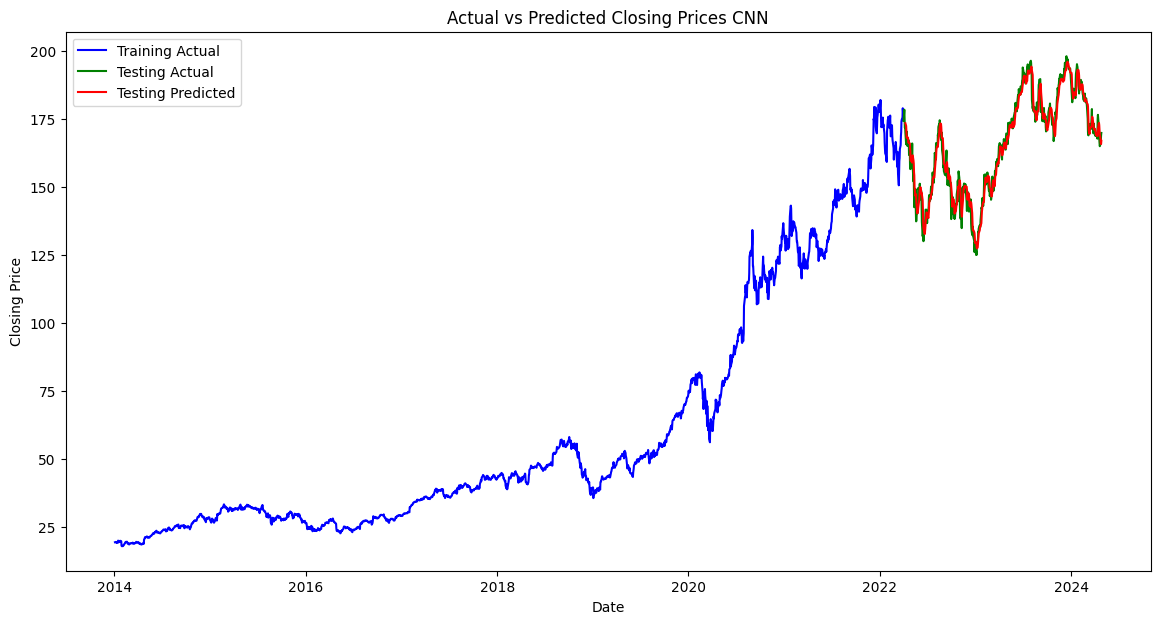

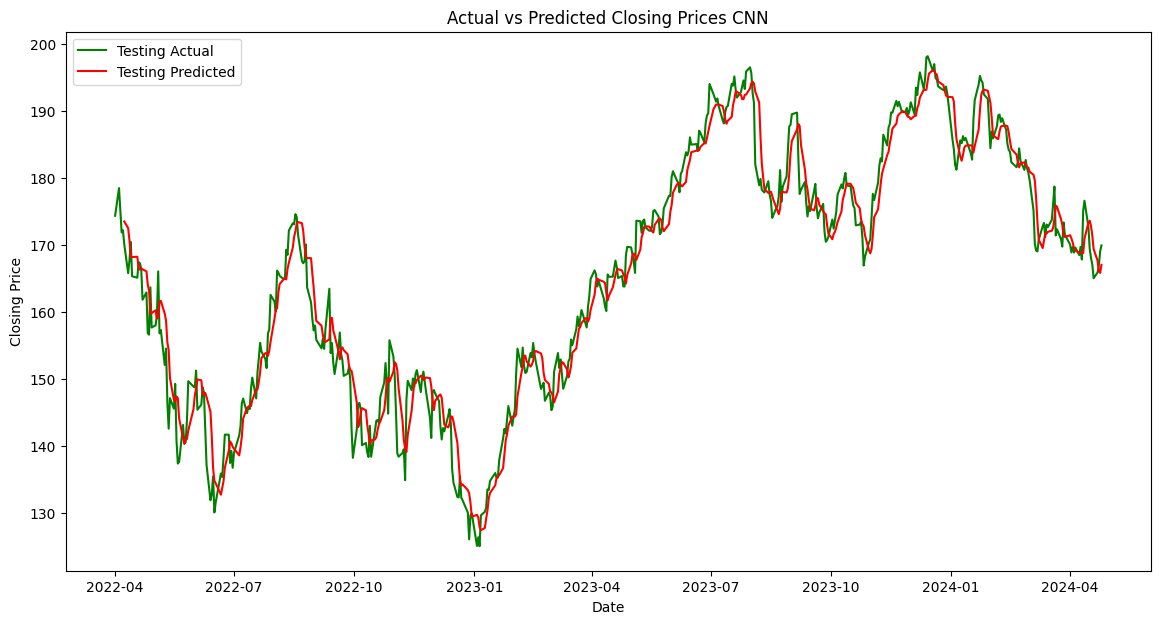

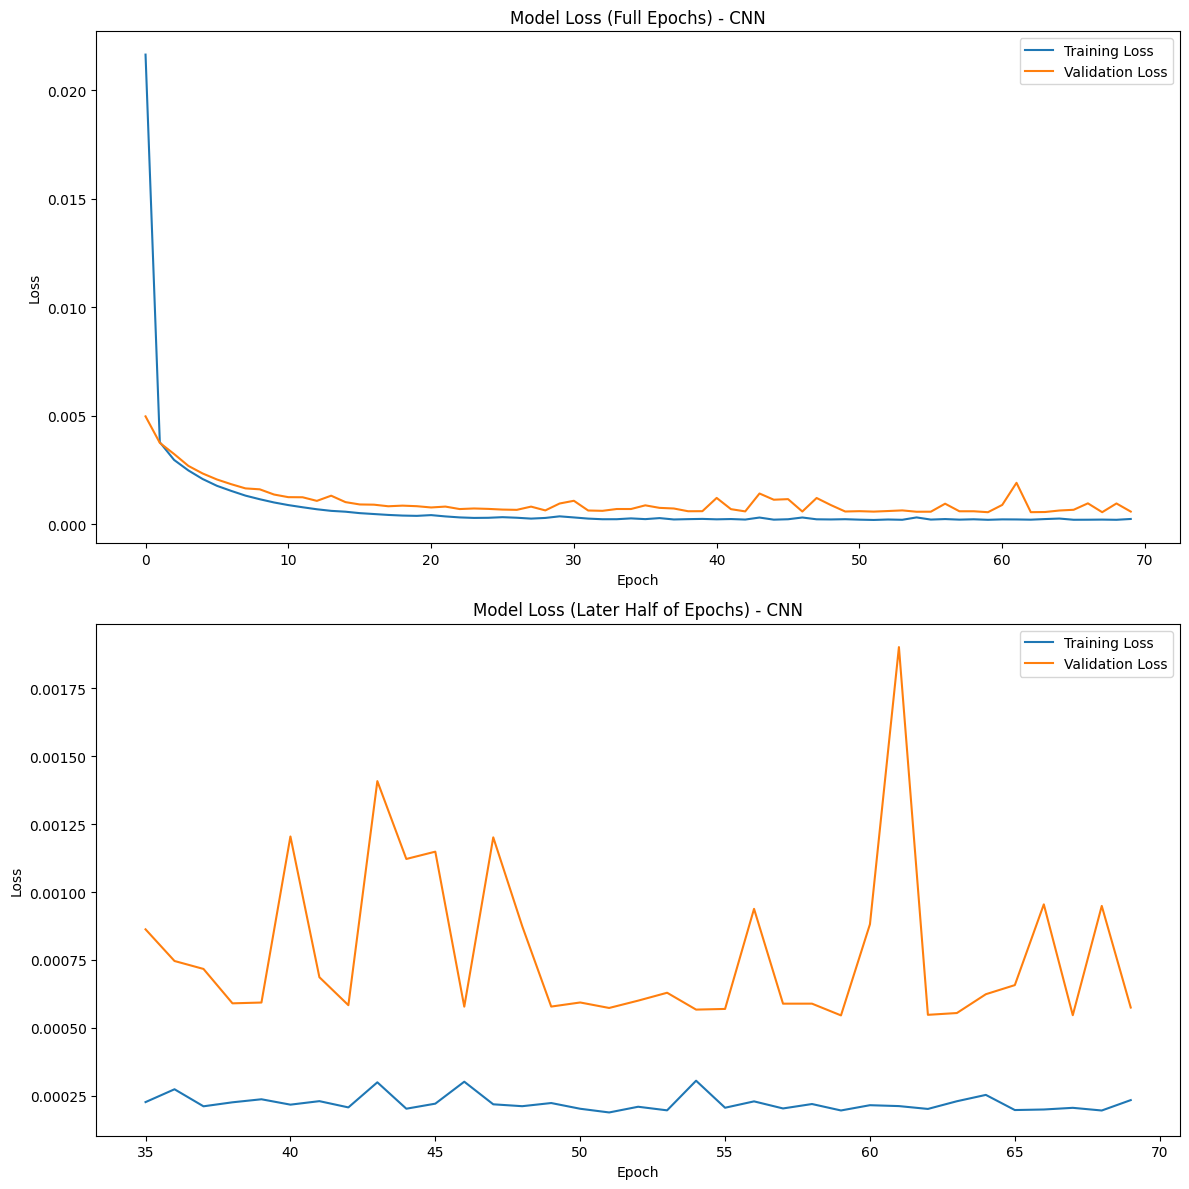

In [30]:
#Visualization
y_pred_test_cnn_vis = scaler.inverse_transform(y_pred_test_cnn)
plotter = StockPricePlotter(stock_data,model="CNN",time_steps=5)
plotter.plot_prices(train, test, y_pred_test_cnn_vis)
plotter.plot_test_vs_prediction(test, y_pred_test_cnn_vis)
plotter.plot_loss(history_cnn)

Based on the result metrics and plot, we can see that CNN acutally peformed better than the feedforward neural network model. CNN model captures the spikes and the fluctuations of the prices and the non-linear pattern accurately. We believe that CNN obtained an outstanding performance due to the reason that CNN uses only the information on the current window for predicting stock price. CNN are highly effective at extracting local features due to their convolutional layers, which apply filters to capture local patterns within the data, when dealing with small time steps, the stock market's local dependencies and short-term patterns are well captured by the convolutional operations in CNNs.

### 3.3 RNN

We will now attempt the Recurrent Neural Networks model(RNN), which is effective in handling sequential data and analyzing the time-series trends in stock prediction. Stock prices are heavily influenced by past values and patterns over time, and RNNs can capture these temporal dependencies through their architecture. Mathematically, at each time step $t_i$, an RNN updates its hidden state $h_t​$ using the previous hidden state $h_{t-1}$ and the current input $x_t$. This can be expressed as $h_t = σ(W_h h_{t-1} + W_x x_t + b)$, where $W_h$ and $W_x$ are weight matrices, b is the bias vector, and $σ$ is the non-linear activation function.


Like the CNN, before building the model, we will first do the data preprocessing for the RNN model by reshape it into the corresponding dimension.

In [31]:
#Pre-processing for RNN
X_train_rnn, y_train_rnn = create_dataset(scaled_train, time_steps = 5)
X_test_rnn, y_test_rnn = create_dataset(scaled_test, time_steps = 5)

#Convert the data to numpy array
X_train_rnn, y_train_rnn = np.array(X_train_rnn), np.array(y_train_rnn)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1],1))
y_train_rnn = y_train_rnn.reshape((y_train_rnn.shape[0],1))
print(X_train_rnn.shape, y_train_rnn.shape)

#Convert the data to numpy array
X_test_rnn, y_test_rnn = np.array(X_test_rnn), np.array(y_test_rnn)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_test_rnn = X_test_rnn.reshape((X_test_rnn.shape[0], X_test_rnn.shape[1],1))
y_test_rnn = y_test_rnn.reshape((y_test_rnn.shape[0],1))
print(X_test_rnn.shape, y_test_rnn.shape)

(2071, 5, 1) (2071, 1)
(514, 5, 1) (514, 1)


After completing the data preprocessing, we will construct a Recurrent Neural Network (RNN) model using Keras Tuner to optimizer the model's hypterparmeters. The RNN model consists of three layers of SimpleRNN units, each with tunable parameters including the number of units and the activation function. Our goal is to determine the optimal congifuration of these hyperparameters to achieve the best performance in predicting stock prices. By utilizing Keras Tunner's RandomSearch, which is a hyperparameter optimization technique used to tune the hyperparameters of machine learning models. Unlike grid search, which systematically explores all possible combinations of hyperparameters, random search samples the hyperparameter space randomly. This method can be more efficient and effective, especially when dealing with high-dimensional hyperparameter spaces. We search through various combination of units ranging from 32 to 512, and the activation functions ('tanh' and 'relu') for each RNN model. We will define a class that specifies the architecture and hyperparameters and then using the tuner to fit the model.

In [32]:
class RNNhyperModel(HyperModel):
    '''
    A hypermodel class for building an RNN with hyperparameter tuning for units, activation functions, and regularization in each RNN layer.

    Attributes:
    input_shape: The shape of the input data
    '''

    def __init__(self, input_shape):
        '''
        Initializes the RNNhyperModel with the given input shape

        Argument:
        input_shape: The shape of the input data, excluding the batch size
        '''
        self.input_shape = input_shape

    def build(self, hp):
        '''
        Builds the RNN model with hyperparameter tuning for the number of units, activation functions, and regularization in each RNN layer.

        Args:
        hp: Hyperparameters object for tuning.

        Returns:
        A compiled RNN model with the specified hyperparameters.
        '''
        model = tf.keras.models.Sequential()

        # First RNN layer with hyperparameter tuning for units, activation function, and regularization
        model.add(layers.SimpleRNN(
            units=hp.Int('units_1', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_1', values=['tanh', 'relu']),
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            input_shape=self.input_shape
        ))

        # Second RNN layer with hyperparameter tuning for units, activation function, and regularization
        model.add(layers.SimpleRNN(
            units=hp.Int('units_2', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_2', values=['tanh', 'relu']),
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_2', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))

        # Third RNN layer with hyperparameter tuning for units, activation function, and regularization
        model.add(layers.SimpleRNN(
            units=hp.Int('units_3', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_3', values=['tanh', 'relu']),
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_3', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))

        # Output layer
        model.add(layers.Dense(units=1, activation='linear'))

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mean_squared_error',
            metrics=['mse'])

        return model

input_shape = (X_train_rnn.shape[1],1)
hypermodel = RNNhyperModel(input_shape=input_shape)


#Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='mse',
    max_trials=20,  # Number of models to try
    executions_per_trial=2,  # Number of times to train each model
    directory='my_dir',
    project_name='rnn_tuning'
)

#set up early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#search for the best hyperparameters
tuner.search(X_train_rnn, y_train_rnn, epochs=100, validation_data=(X_test_rnn, y_test_rnn), batch_size = 32, callbacks=[early_stopping])

#get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#build the model with the optimal hyperparameters
model_rnn = hypermodel.build(best_hps)

#Best hyperparameters
print("Best hyperparameters: ", best_hps.values)
model_rnn.summary()

#Train the model
history_rnn = model_rnn.fit(X_train_rnn, y_train_rnn, epochs=100, validation_data=(X_test_rnn, y_test_rnn), batch_size=32,verbose = 1,
                            callbacks=[early_stopping])

#Make predictions
y_pred_train_rnn = model_rnn.predict(X_train_rnn)
y_pred_test_rnn = model_rnn.predict(X_test_rnn)

#evaluate the model
train_mse_rnn = mean_squared_error(y_train_rnn, y_pred_train_rnn)
test_mse_rnn = mean_squared_error(y_test_rnn, y_pred_test_rnn)


print(f'RNN - Training MSE: {train_mse_rnn}')
print(f'RNN - Testing MSE: {test_mse_rnn}')

Reloading Tuner from my_dir\rnn_tuning\tuner0.json
Best hyperparameters:  {'units_1': 320, 'activation_1': 'relu', 'units_2': 384, 'activation_2': 'relu', 'units_3': 352, 'activation_3': 'relu', 'learning_rate': 0.0007159994565305996, 'l2_1': 0.0001, 'l2_2': 0.0001, 'l2_3': 0.0001}


C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 5, 320)              │         103,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 5, 384)              │         270,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 352)                 │         259,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,537 (2.42 MB)

 Trainable params: 633,537 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0841 - mse: 0.0228 - val_loss: 0.0388 - val_mse: 7.0701e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0346 - mse: 3.1018e-04 - val_loss: 0.0268 - val_mse: 6.2546e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - mse: 2.0625e-04 - val_loss: 0.0216 - val_mse: 9.1668e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199 - mse: 2.4694e-04 - val_loss: 0.0181 - val_mse: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - mse: 2.4021e-04 - val_loss: 0.0154 - val_mse: 0.0011
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - mse: 2.5079e-04 - val_loss: 0.0125 - val_mse: 5.2621e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - mse: 2.6344e-04 - val_loss: 0.0122 - val_mse: 0.0019
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - mse: 4.9056e-04 - val_loss: 0.0106 - val_mse: 0.0019
Epoch 9/100
65/65 ━

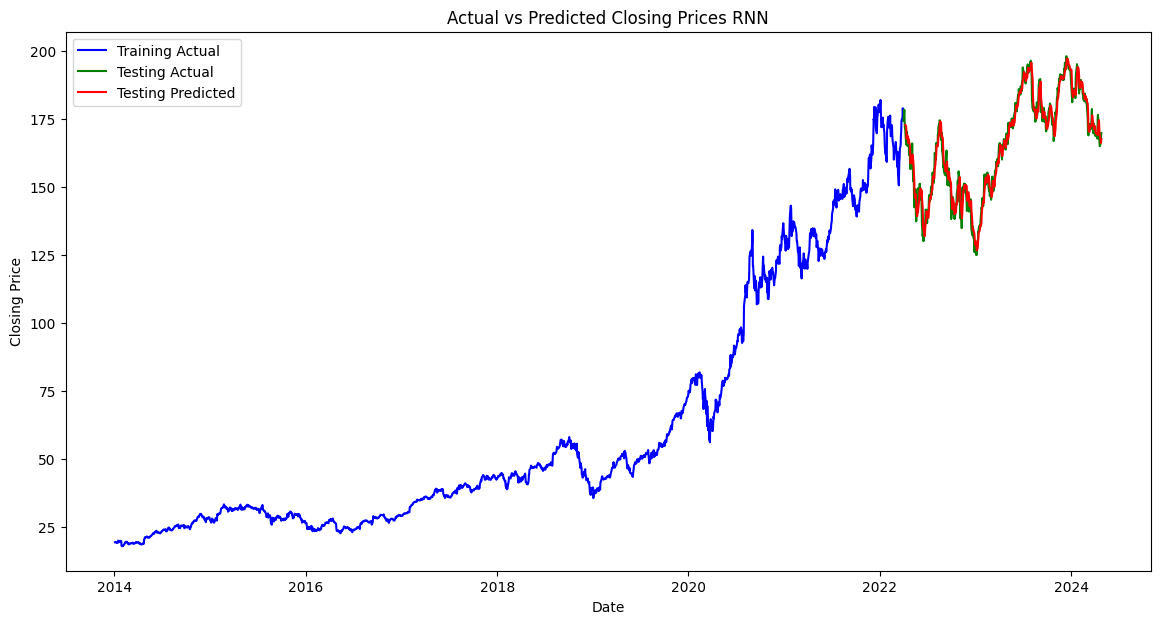

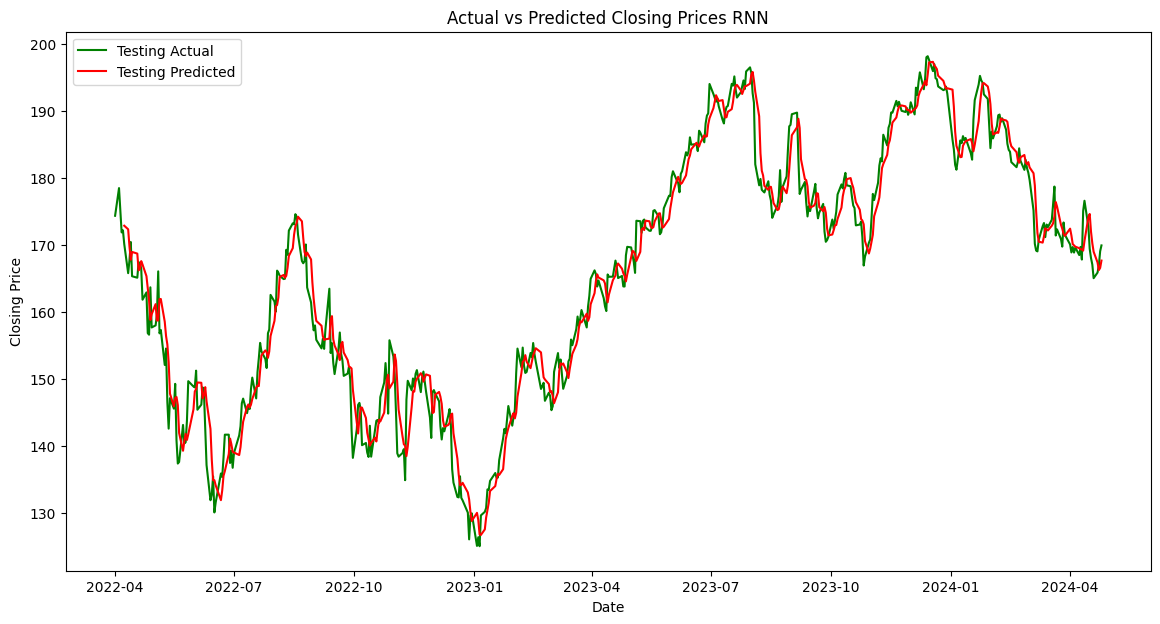

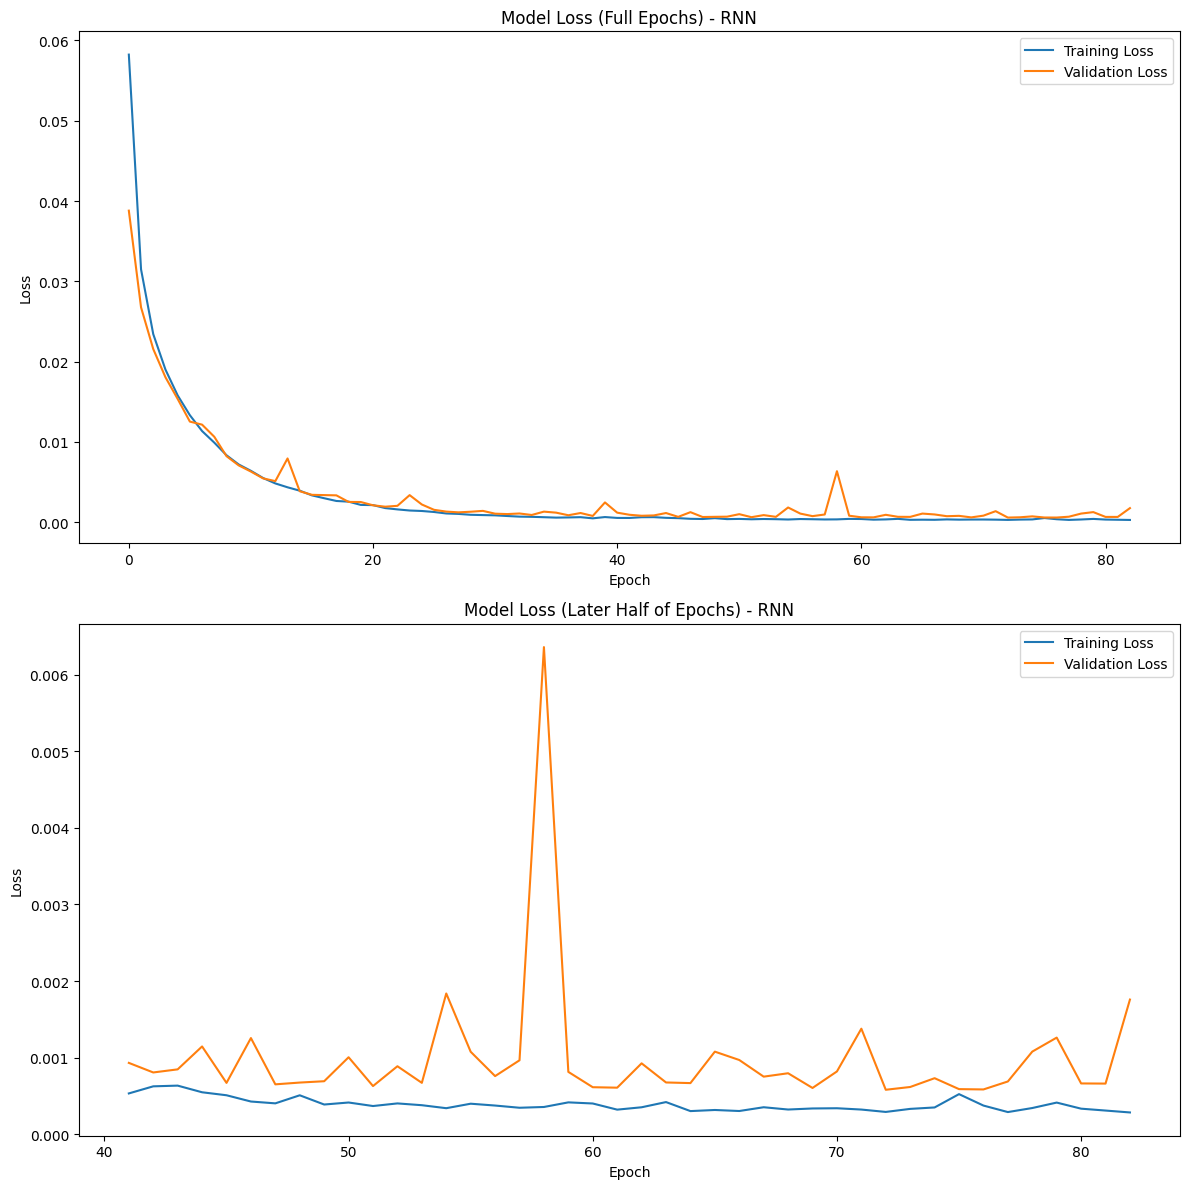

In [33]:
#Visualization
y_pred_test_rnn_vis = scaler.inverse_transform(y_pred_test_rnn)
plotter = StockPricePlotter(stock_data,model="RNN",time_steps=5)
plotter.plot_prices(train, test, y_pred_test_rnn_vis)
plotter.plot_test_vs_prediction(test, y_pred_test_rnn_vis)
plotter.plot_loss(history_rnn)

After performing the hyperparameter tuning with Keras Tuner, we obtained the optimized hyperparameters for each layer. The obtained MSE is really low. Based on the Actual vs Predicted Closing Prices，we see that the RNN model was able to accurately capture the spike and non-linear pattern of the data.


### 3.4 LSTM (Long Short Term Memory)


**Introduction to LSTM**

The Long Short-Term Memory (LSTM) network is a recurrent neural network (RNN) suitable for processing time series data (like in our case, stock prices), especially aiming to deal with the vanishing gradient problem present in traditional RNNs.

The LSTM architecture is designed so that long term memory can be preserved with diminishing impact in the prediction by recurrently updating a long term and a short term memory. Before constructing the model, let's preprocess the data

In [34]:
#preprocessing of the data
X_train_lstm, y_train_lstm = create_dataset(scaled_train, time_steps = 60)
X_test_lstm, y_test_lstm = create_dataset(scaled_test, time_steps = 60)

#Convert the data to numpy array
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1],1))
y_train_lstm = y_train_lstm.reshape((y_train_lstm.shape[0],1))
print(X_train_lstm.shape, y_train_lstm.shape)

#Convert the data to numpy array
X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1],1))
y_test_lstm = y_test_lstm.reshape((y_test_lstm.shape[0],1))
print(X_test_lstm.shape, y_test_lstm.shape)

(2016, 60, 1) (2016, 1)
(459, 60, 1) (459, 1)


We wil build the Long Short Term Memory (LSTM) model using the Keras's framework annd Keras Tuner to optimize its hyperparameters effectively. The core of our LSTM model consists of multiple LSTM layers, which are adept at capturing long-term dependeices and temporal pattern in sequential data. The architecture begins with an input LSTM layer where the number of units (neurons) and the activation function are subject to hyperparameter tuning. This layer is configured to return sequences to feed subsequent LSTM layers, enhancing the model's depth and learning capacity. Following the initial LSTM layer, our model incorporates additional LSTM layers, the number of which is also determined by the tuning process. Each of these layers can have a different number of units, and the decision to return sequences from these layers is contingent on their position within the network. This structure allows the model to learn hierarchical features of the input time series data. The final LSTM layer, however, does not return sequences, preparing the output for the dense layer. The final layer of the model is a dense layer with a single unit. The model is tuned for optimal performance and also tuning the optimizer. Then we employed Keras Tuner's RandomSearch method to explore the hyperparameter space, including the number of units in each LSTM layer, activation functions, the number of LSTM layers, loss functions, and optimizers. This search is executed over multiple trials, each training the model for 50 epochs with a batch size of 12. The optimized model is expected to capture the complex patterns in stock price movements and providing accurate predictions.

In [35]:
#define the HyperModel class for the LSTM model
class LSTMHyperModel(HyperModel):
    '''
    A hypermodel class for building a Long Short Term Memory model with hyperparameter tuning
    for units, activation functions, and dropout rates.

    Attributes:
        input_shape: The shape of the input data.
    '''
    def __init__(self, input_shape):
        '''
        Initializes the LSTMHyperModel with the given input shape.

        Arguments:
            input_shape: The shape of the input data, excluding the batch size.
        '''
        self.input_shape = input_shape

    def build(self, hp):
        '''
        Builds the LSTM model with hyperparameter tuning

        Arguments:
            hp (keras_tuner.HyperParameters): Hyperparameters object for tuning.

        Returns:
            A compiled model with the specified hyperparameters.
        '''

        model = Sequential()

        #First LSTM layer with hyperparameter tuning for units and activation function
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
                       activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                       input_shape=self.input_shape,
                       return_sequences=True))

        # Additional LSTM layers based on hyperparameter tuning
        for i in range(hp.Int('n_layers', 1, 3)):
            model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=256, step=32),
                           return_sequences=(i != hp.Int('n_layers', 1, 3) - 1)))

        # Output layer
        model.add(Dense(units=1))

        # Compile the model
        model.compile(loss=hp.Choice('loss', values=['mean_squared_error', 'mean_absolute_error']),
                      optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                      metrics=['mse'])

        return model

input_shape = (X_train_lstm.shape[1], 1)
hypermodel = LSTMHyperModel(input_shape=input_shape)

# Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,  # Number of models to try
    executions_per_trial=2,  # Number of times to train each model
    directory='my_dir',
    project_name='lstm_tuning'
)

#search for the best hyperparameters
tuner.search(X_train_lstm, y_train_lstm, epochs=50, batch_size=12, validation_data=(X_test_lstm, y_test_lstm))

#get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#build the model with the optimal hyperparameters
model_lstm = hypermodel.build(best_hps)

print("Best hyperparameters: ", best_hps.values)
model_lstm.summary()

#train the model
history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, validation_data=(X_test_lstm, y_test_lstm), batch_size=12, verbose = 1)

#Make predictions
y_pred_train_lstm = model_lstm.predict(X_train_lstm)
y_pred_test_lstm = model_lstm.predict(X_test_lstm)

# Evaluate the model
train_mse_lstm = mean_squared_error(y_train_lstm, y_pred_train_lstm)
test_mse_lstm = mean_squared_error(y_test_lstm, y_pred_test_lstm)

print(f'LSTM - Training MSE: {train_mse_lstm}')
print(f'LSTM - Testing MSE: {test_mse_lstm}')

Reloading Tuner from my_dir\lstm_tuning\tuner0.json
Best hyperparameters:  {'units': 96, 'activation': 'sigmoid', 'n_layers': 1, 'lstm_0_units': 160, 'loss': 'mean_squared_error', 'optimizer': 'rmsprop'}


C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 160)                 │         164,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,273 (790.13 KB)

 Trainable params: 202,273 (790.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2313 - mse: 0.2313 - val_loss: 0.2698 - val_mse: 0.2698
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━

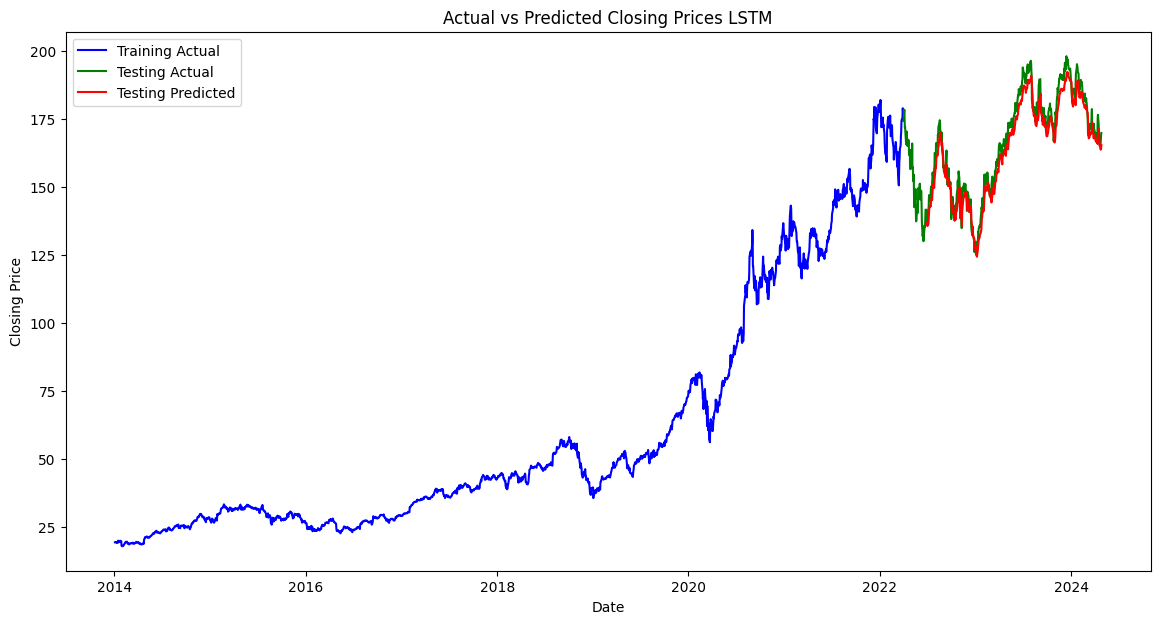

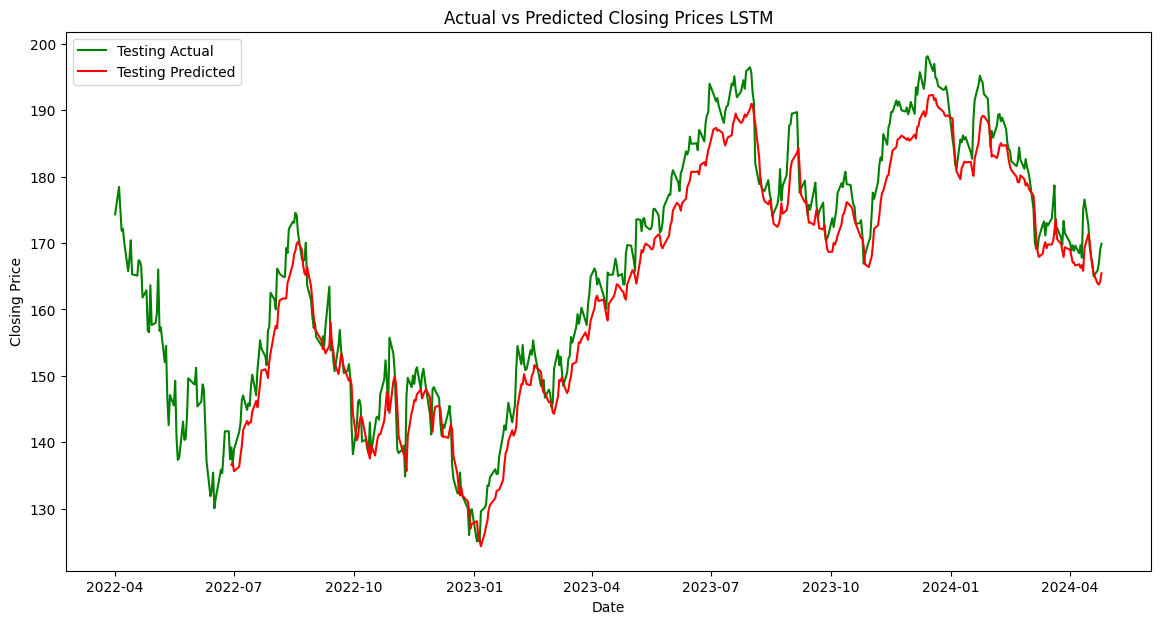

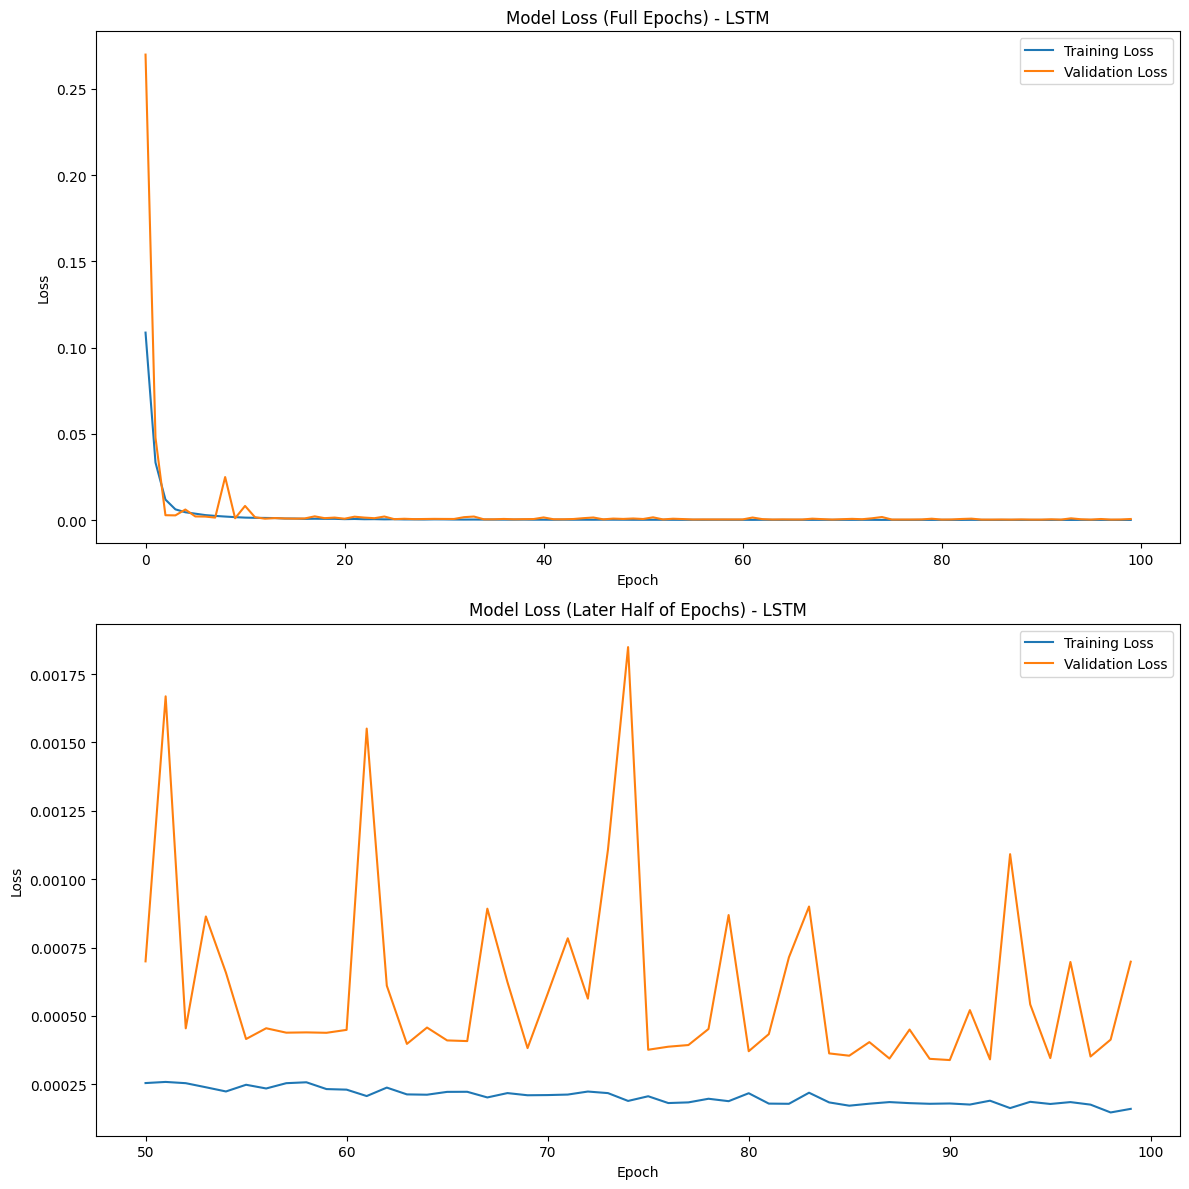

In [36]:
#Visualization
y_pred_test_lstm_vis = scaler.inverse_transform(y_pred_test_lstm)
plotter = StockPricePlotter(stock_data,model="LSTM",time_steps=60)
plotter.plot_prices(train, test, y_pred_test_lstm_vis)
plotter.plot_test_vs_prediction(test, y_pred_test_lstm_vis)
plotter.plot_loss(history_lstm)

We observe that its prediction is capable of capturing all the up-and-down trends of the prices, but it falls short of accounting for the noises (spikes). Numerically, the predicted prices tend to be a little higher than the actual price in general.

From the first training and validation loss plot, we have the following observations: \
Between first few epochs, training  losses rapidly decrease. Between 10-20 epochs, the losses reduce slowly. Between 20 - 100 epochs, loss decreases very slowly (nearly flattens), which indicates that the model is fully trained. We read rather low model validation loss, which arrived at a stabilizing average of about 0.0010(sunject to change on each run). However, the validation loss plot is punctuated by frequent, sharp spikes  indicating unstable performance of the Model. Plus, the validation loss average is about twice the stabilizing average of the training loss which reads about 0.0005(sunjects to change on each run), signaling potential overfitting.


Another commonly used RNN model specialized in handling time-series data is GRU. Moving on to explore GRU's performance in our task, we will seek to mitigate the overfitting we encountered in LSTM, whose achitecture is similar to GRU.

### 3.5 GRU (Gated recurrent units)



Gated Recurrent Unit (GRU) models are a type of recurrent neural network designed to address the vanishing gradient problem by incorporating gating mechanisms that regulate the flow of information through the network, allowing them to maintain and update a more stable memory state over longer sequences. A GRU model consists of two primary gates: the rest gate $r_t$ and the update gate $z_t$. The reset gate determines how much the previous state $h_{t-1}$ to forget, while the update gate controls how much of the new state $h_t$ to incorporate. Mathematically, the update gate is computed as $z_t = \sigma(W_z * [h_{t-1}, x_t]) $, where $W_z$ is the weight matrix for the update gate, $\sigma$ is the activation function, $h_{t-1}$ is the previous hidden state, and the $x_t$ is the current input. The reset gate is similarly computed as $r_t = \sigma(W_r *[h_{t-1}, x_t])$. The candidate hidden state is then calculated using the reset gate: $h_t = tanh(W *[r_t * h_{t-1}, x_t])$. The final hiddne state $h_t$ is updated as $h_t = (1 - z_t) * h_{t-1} + z_t * $ the candidate hidden state. These mechanisms enable GRUs to efficiently capture dependencies in sequential data, which is particularly suitable for time series predictions.

We will now attempt the Gated Recurrent Unit (GRU) model, like our previous models, we need to preprocess the data to fit the expected input shape of the GRU layers.

In [37]:
#Preprocessing for GRU
X_train_gru, y_train_gru = create_dataset(scaled_train, time_steps = 5)
X_test_gru, y_test_gru = create_dataset(scaled_test, time_steps = 5)

#Convert the data to numpy array
X_train_gru, y_train_gru = np.array(X_train_gru), np.array(y_train_gru)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_train_gru = X_train_gru.reshape((X_train_gru.shape[0], X_train_gru.shape[1],1))
y_train_gru = y_train_gru.reshape((y_train_gru.shape[0],1))
print(X_train_gru.shape, y_train_gru.shape)

#Convert the data to numpy array
X_test_gru, y_test_gru = np.array(X_test_gru), np.array(y_test_gru)

#Reshaping input to 3D: (number of sample, time_steps, 1)
X_test_gru = X_test_gru.reshape((X_test_gru.shape[0], X_test_gru.shape[1],1))
y_test_gru = y_test_gru.reshape((y_test_gru.shape[0],1))
print(X_test_gru.shape, y_test_gru.shape)

(2071, 5, 1) (2071, 1)
(514, 5, 1) (514, 1)


After preprocessing the data, we build and train the GRU model by leveraging Keras Tuner to optimize its hyperparameters.

The model comprises three GRU layers, each with tunable paramerts including the number of units (ranging from 32 to 512), activation functions (choices between 'tanh','relu'), and dropout rates (ranging from 0.1 to 0.5). Regularization penalties on kernels are applied on a per-layer basis, with choices ranging from 1e-4 to 1e-2. These layers are followed by dropout layers to prevent overfitting and a dense layer with a sigmoid activation function for the final output. We will still use the Keras'Tuner's RandomSearch algorithm is utilized to explore the hyperparameter space and find the optimal congifuration that can minimizes the MSE on the validation data. We incorporate early stopping for both hyperparameter tuning and model training processes to further mitigate overfitting. Through Keras Tuner, we ensures that the GRU is finely tuned to capture both short-term and long-term trend of the stock data, strenghting the predictive accuracy.

In [38]:
class GRUHyperModel(HyperModel):
    '''
    A hypermodel class for building a Gated Recurrent Unit model with hyperparameter tuning
    for units, activation functions, dropout rates, and regularization.

    Attributes:
        input_shape: The shape of the input data.
    '''
    def __init__(self, input_shape):
        '''
        Initializes the GRUHyperModel with the given input shape.

        Arguments:
            input_shape: The shape of the input data, excluding the batch size.
        '''
        self.input_shape = input_shape

    def build(self, hp):
        '''
        Builds the GRU model with hyperparameter tuning for the number of units, activation functions,
        dropout rates, and regularization.

        Arguments:
            hp (keras_tuner.HyperParameters): Hyperparameters object for tuning.

        Returns:
            A compiled GRU model with the specified hyperparameters.
        '''
        model = Sequential()

        # First GRU layer with hyperparameter tuning for units, activation function, and regularization
        model.add(GRU(
            units=hp.Int('units_1', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_1', values=['tanh', 'relu']),
            return_sequences=True,
            input_shape=self.input_shape,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

        # Second GRU layer with hyperparameter tuning for units, activation function, and regularization
        model.add(GRU(
            units=hp.Int('units_2', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_2', values=['tanh', 'relu']),
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_2', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

        # Third GRU layer with hyperparameter tuning for units, activation function, and regularization
        model.add(GRU(
            units=hp.Int('units_3', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_3', values=['tanh', 'relu']),
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_3', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        ))
        model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(units=1, activation='linear'))

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mean_squared_error',
            metrics=['mse'])

        return model

input_shape = (X_train_gru.shape[1], 1)
hypermodel = GRUHyperModel(input_shape=input_shape)

#Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='mse',
    max_trials=20,  #Number of models to try
    executions_per_trial=2,  #Number of times to train each model
    directory='my_dir',
    project_name='gru_tuning'
)
#set up early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Search for the best hyperparameters
tuner.search(X_train_gru, y_train_gru, epochs=100, validation_data =(X_test_gru, y_test_gru), batch_size=32, callbacks=[early_stopping])

#Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#Build the model with the optimal hyperparameters
model_gru = hypermodel.build(best_hps)

#Print the best hypterparameters
print("Best hyperparameters: ", best_hps.values)
model_gru.summary()

#Train the model
history_gru = model_gru.fit(X_train_gru, y_train_gru, epochs=100, validation_data=(X_test_gru, y_test_gru),batch_size = 32,verbose = 1, callbacks =[early_stopping])

#Make predictions
y_pred_train_gru = model_rnn.predict(X_train_gru)
y_pred_test_gru = model_rnn.predict(X_test_gru)

# Evaluate the model
train_mse_gru = mean_squared_error(y_train_gru, y_pred_train_gru)
test_mse_gru = mean_squared_error(y_test_gru, y_pred_test_gru)

print(f'GRU - Training MSE: {train_mse_gru}')
print(f'GRU - Testing MSE: {test_mse_gru}')

Reloading Tuner from my_dir\gru_tuning\tuner0.json
Best hyperparameters:  {'units_1': 224, 'activation_1': 'tanh', 'dropout_1': 0.2, 'units_2': 224, 'activation_2': 'relu', 'dropout_2': 0.1, 'units_3': 416, 'activation_3': 'tanh', 'dropout_3': 0.1, 'learning_rate': 0.002291934920273138, 'l2_1': 0.0001, 'l2_2': 0.0001, 'l2_3': 0.0001}


C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 5, 224)              │         152,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 224)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 5, 224)              │         302,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 224)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 416)                 │         801,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,256,577 (4.79 MB)

 Trainable params: 1,256,577 (4.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0663 - mse: 0.0280 - val_loss: 0.0114 - val_mse: 8.6647e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0100 - mse: 8.7701e-04 - val_loss: 0.0067 - val_mse: 6.9977e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - mse: 5.9327e-04 - val_loss: 0.0045 - val_mse: 7.7243e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - mse: 6.2472e-04 - val_loss: 0.0042 - val_mse: 0.0017
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - mse: 0.0012 - val_loss: 0.0039 - val_mse: 0.0022
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - mse: 9.8606e-04 - val_loss: 0.0027 - val_mse: 0.0015
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - mse: 7.1509e-04 - val_loss: 0.0037 - val_mse: 0.0027
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017 - mse: 7.5795e-04 - val_loss: 0.0015 - val_mse: 7.0118e-04
Epoch 9/100
65/6

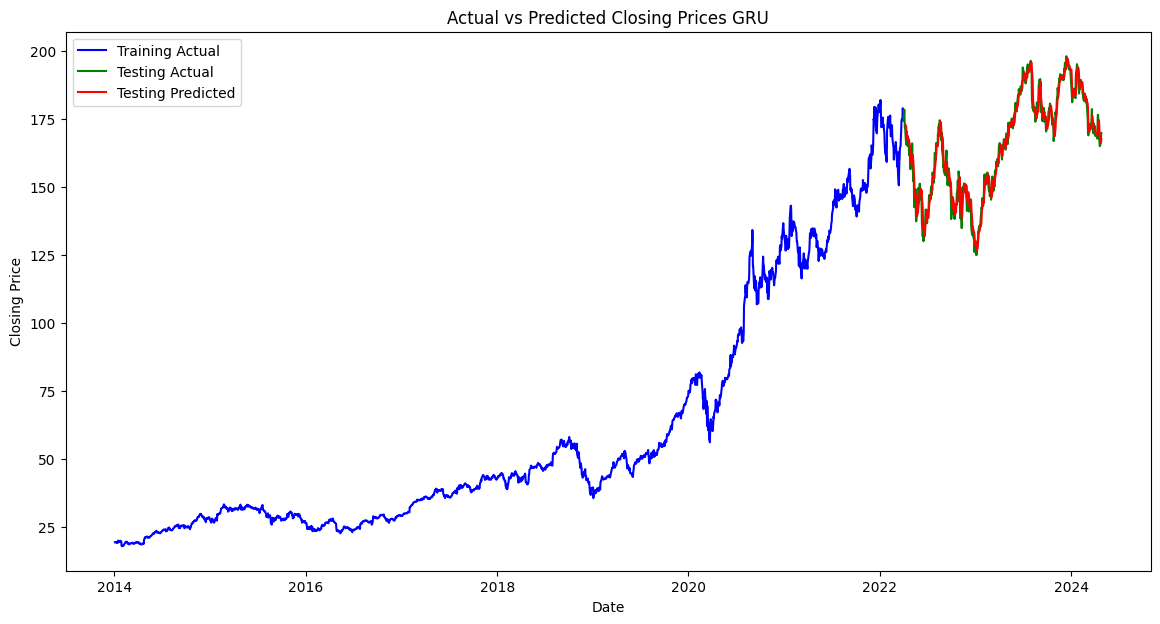

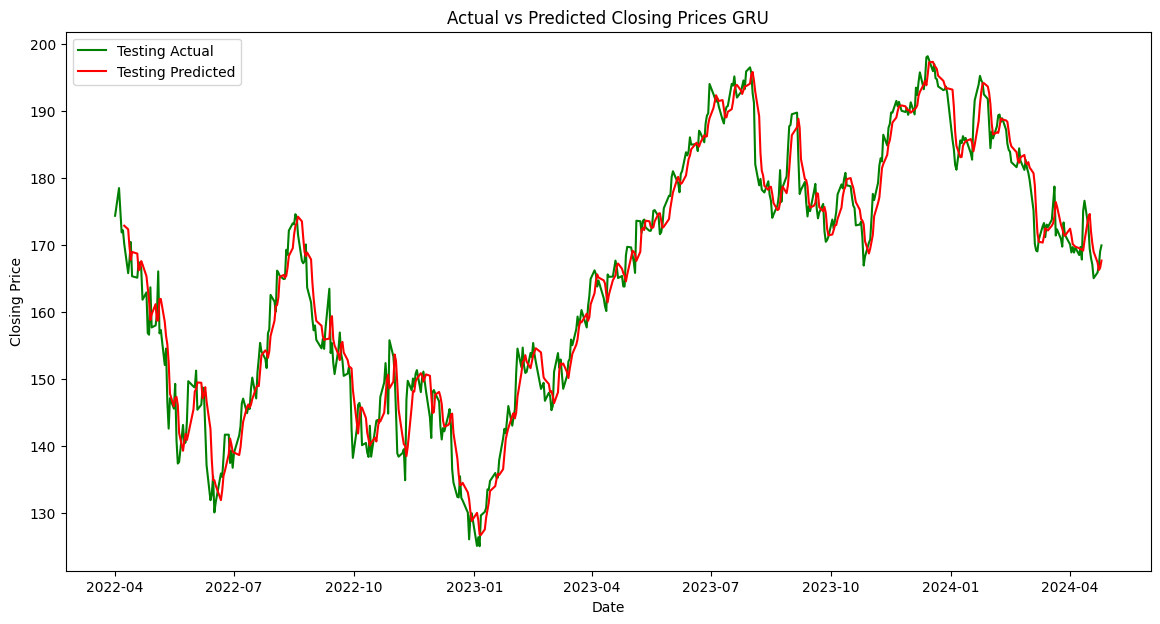

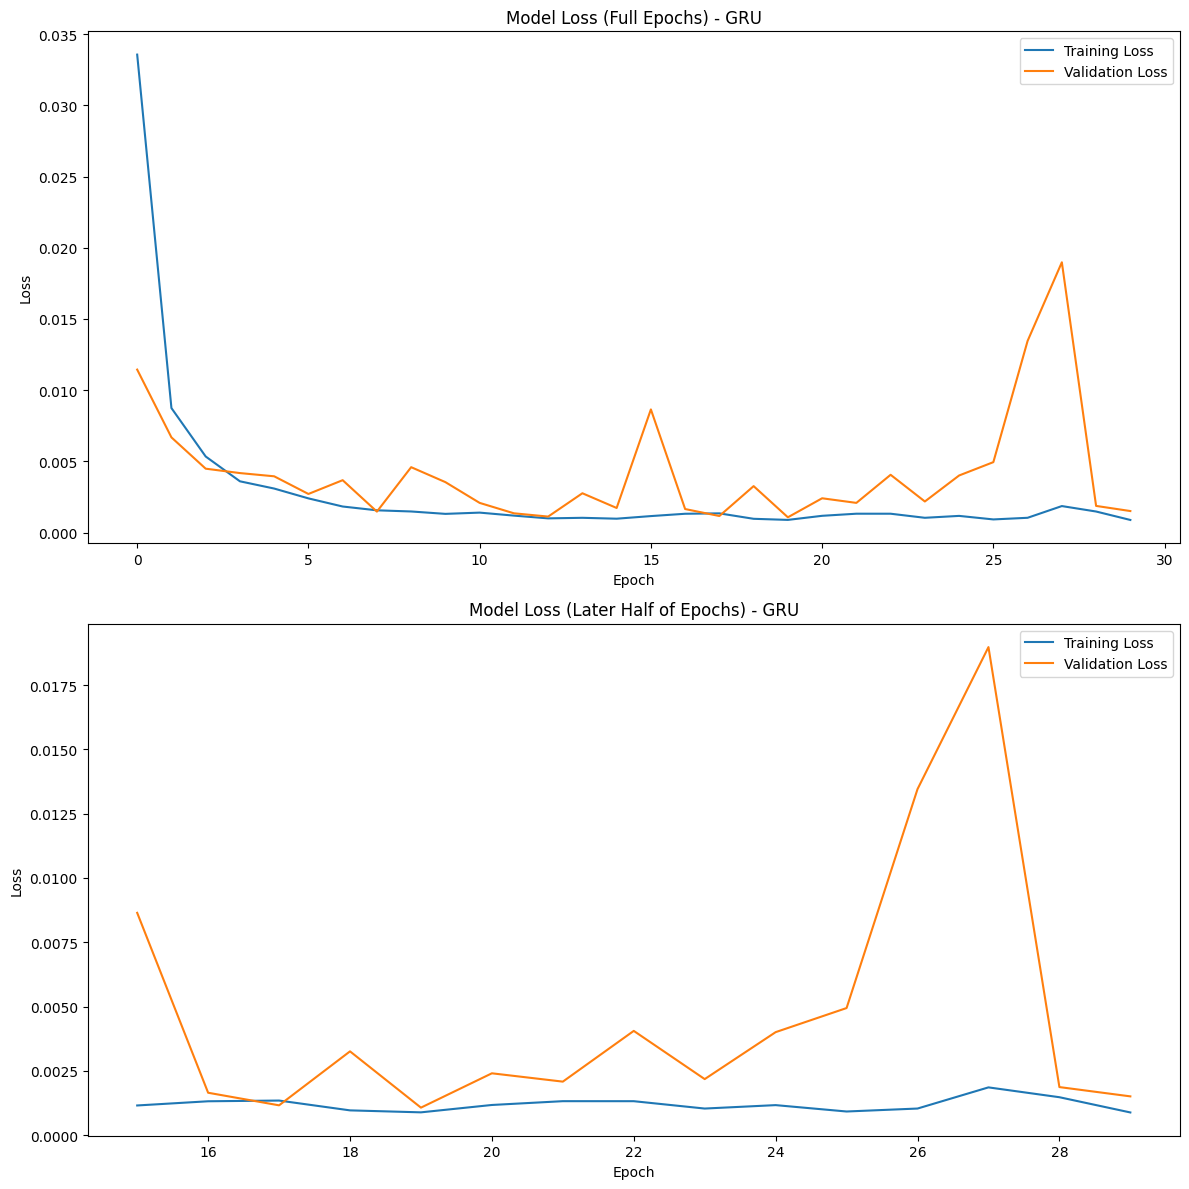

In [39]:
#Visualization
y_pred_test_gru_vis = scaler.inverse_transform(y_pred_test_gru)
plotter = StockPricePlotter(stock_data,model="GRU",time_steps=5)
plotter.plot_prices(train, test, y_pred_test_gru_vis)
plotter.plot_test_vs_prediction(test, y_pred_test_gru_vis)
plotter.plot_loss(history_gru)

From the Actual vs Prediction price of GRU model, we see that GRU is able to preserve the spikes of prices and takes into account most tunring points in the price data. There seemed to be no signs of overshooting or undershooting.
The validation loss,however, overtakes the training loss after the 20th epoch, and remained greater than training loss, indicating overfitting of the GRU model.

### 3.6 AutoRegressive Integrated Moving Average (ARIMA)

ARIMA is short for Auto-Regressive Integrated Moving Average, a class of statistical models for time series forecasting. ARIMA forecasts the next step in a time series using a linear function of the differenced observations and residual errors from previous time steps.\
 An important assumption of the ARIMA models is that the time series data is stationary.\  A stationary time series is one whose statistical properties like the mean, variance, and auto-correlation are all constant over time. In other words, in stationary time-series data, the properties or value of a sample observation does not depend on the timestamp at which it is observed. This assumption makes it easier for ARIMA to model the data and make predictions.


The ARIMA model can be broken down into 3 parts: AR, I, MA, (p,d,q).\
AR means ‘’auto-regressive’’, meaning that the time series is linearly-regressed with its past values. The parameter of AR is p, the number of past values included in the AR model.
$Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \epsilon_t$ \
I stands for integrated, meaning that if not stationary, data can be differenced to become stationary.The corresponding parameter is d, representing the number of time the series is differenced.
$\Delta Y_t = Y_t - Y_{t-1}$ \
MA (moving average) means that the series is regressed on the past forecast errors.
Q is the number of forecast errors included in the MA model.
$Y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}$\
The full ARIMA model formula is : \
$(1 - \phi_1 Y_{t-1} - \phi_2 Y_{t-2} - \ldots - \phi_p Y_{t-p})(1 - B)^d Y_t = (1 + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q}) \epsilon_t$
where $By_t = y_{t-1}$


In the following data preprocessing, we will first stationarize the closing price data and tune the three parameters(p,d,q) of arima_orders both by hand and by systematic methods such as the auto-ARIMA model.


In [40]:
stock_data.head()

Open       High        Low      Close    Adj Close   \
Date                                                                  
2014-01-03  19.750000  19.775000  19.301071  19.320715    16.938305   
2014-01-06  19.194643  19.530000  19.057142  19.426071    17.030676   
2014-01-07  19.440001  19.498571  19.211430  19.287144    16.908880   
2014-01-08  19.243214  19.484285  19.238930  19.409287    17.015959   
2014-01-09  19.530000  19.530714  19.119642  19.161428    16.798664   

                Volume   Daily Return  MA50  MA100  MA200  
Date                                                       
2014-01-03  392467600.0     -0.021966   NaN    NaN    NaN  
2014-01-06  412610800.0      0.005453   NaN    NaN    NaN  
2014-01-07  317209200.0     -0.007152   NaN    NaN    NaN  
2014-01-08  258529600.0      0.006333   NaN    NaN    NaN  
2014-01-09  279148800.0     -0.012770   NaN    NaN    NaN

In [41]:
arima_data = stock_data.copy()

ARIMA model expects stationary data so we first check for stationality of the 'Close' column. To do that, we first use a test called ADF(Augmented Dickey-Fuller ),which is a statistical test used to determine whether a time series is stationary. Specifically, it tests for the presence of a unit root, a condition that indicates non-stationarity.A unit root indicates that the series has a stochastic trend — a pattern that persists over time and can cause the mean and variance of the series to change over time. The ADF test is as follows:\
Null Hypothesis (H0): The time series has a unit root, meaning it is non-stationary.\
Alternative Hypothesis (H1): The time series does not have a unit root, meaning it is stationary.


In [42]:
def stationarity_check(col):
    '''
    Check if the data is stationary

    Argument
    col:column of the input data

    Returns:
    A statement, result on where the data is stationary or non-stationary
    '''
    res = adfuller(col.dropna())
    print("Test Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

In [43]:
stationarity_check(arima_data[' Close '])

Test Statistic: -0.35806541096081324
P-Value: 0.9168684340663446
Non-Stationary


The 'Close' data is non-stationary, so we have to separate trend and seasonality before fitting ARIMA.

<Figure size 640x480 with 0 Axes>

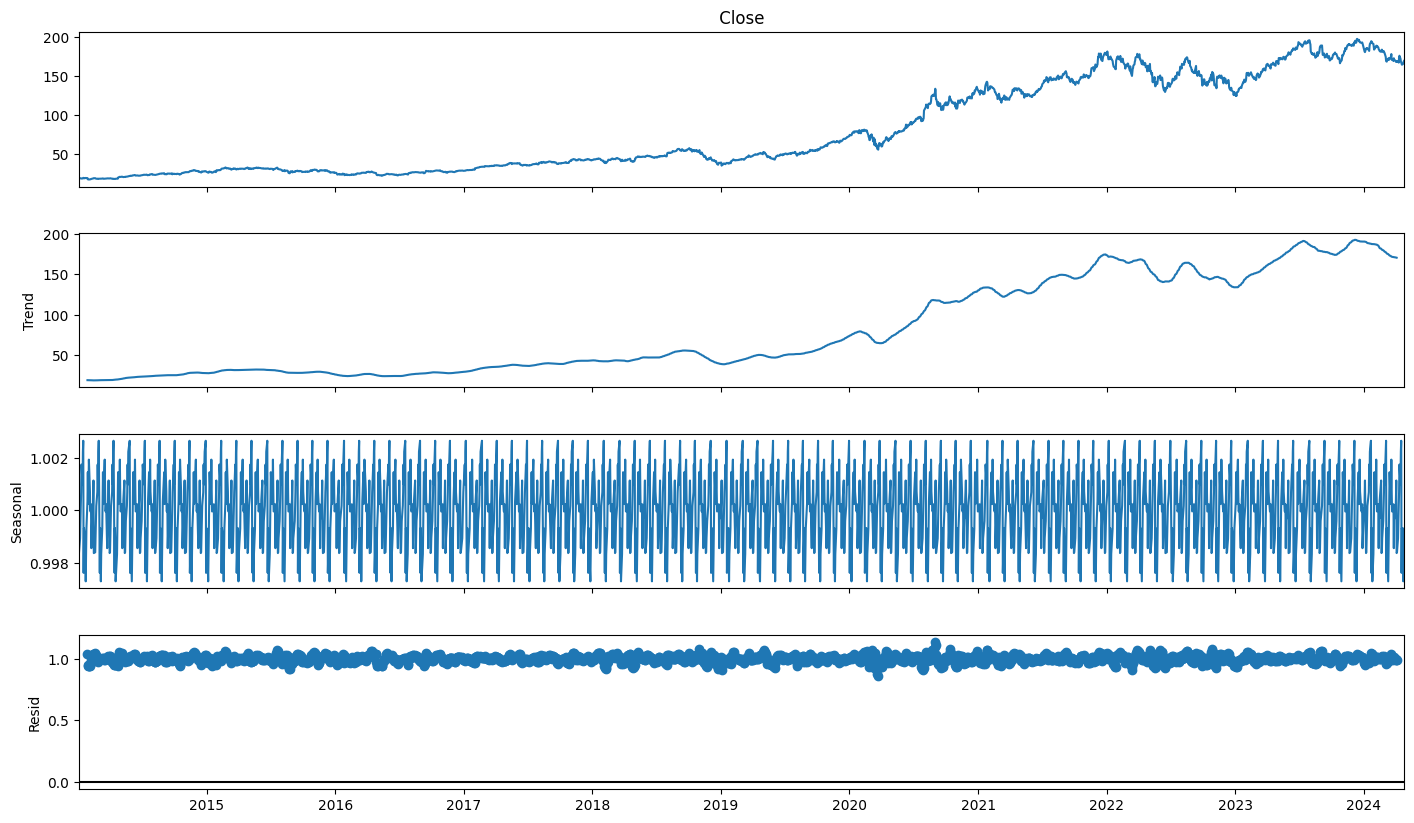

In [44]:
decomposition = seasonal_decompose(arima_data[' Close '],model='multiplicative',period=30)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(16,9)

From the decomposition plot we see that there is indeed a growing trend and some seanonality in the Closing price, so we transform the Closing price to make it stationary.

Before transforming the data to be stationary, let us first do the train test split.

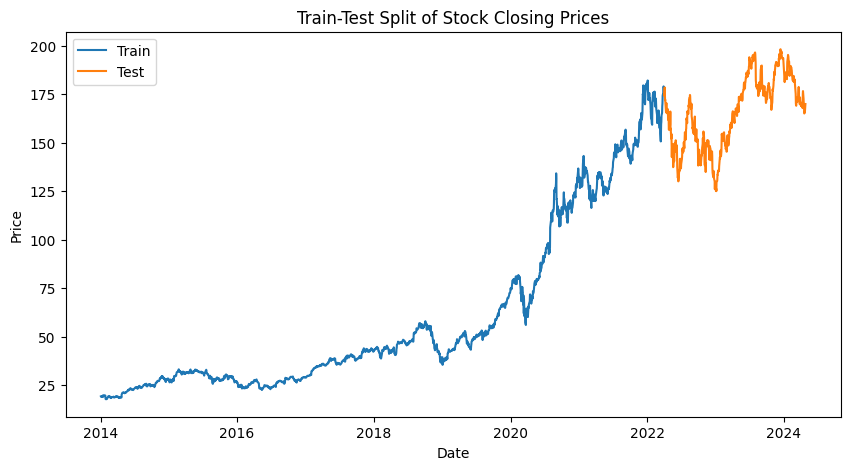

In [45]:
#compute the index for the split
split_point = int(len(arima_data[' Close ']) * 0.8)
train_arima, test_arima = arima_data[' Close '][:split_point], arima_data[' Close '] [split_point:]

# Visualize the train-test split
plt.figure(figsize=(10,5))
plt.plot(train_arima.index, train_arima, label='Train')
plt.plot(test_arima.index, test_arima, label='Test')
plt.title('Train-Test Split of Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Let's apply a technique called "differencing" to
to make the data stationary. Idea behind differency is this that differencing involves computing the differences between consecutive observations in the time series.
The purpose of differencing is to stabilize the mean of the time series and remove trends and seasonality.\
The number of times of differencing applied is the "d" parameter in arima orders.\
After differencing,we trasnformed our prediction of the original closing price to the prediction of the difference between one timestamp and its previous time stamp.

Test Statistic: -9.874769944741164
P-Value: 3.9088905627696275e-17
Stationary


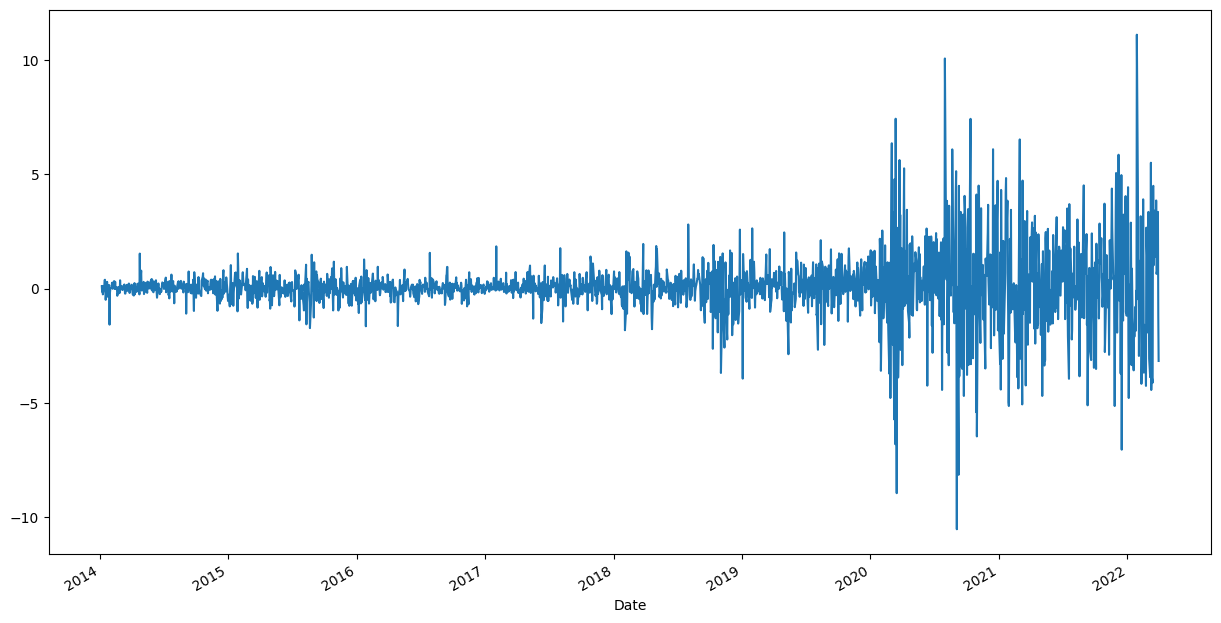

In [46]:
diff_1_close_train = train_arima.diff().dropna()
diff_1_close_train.plot(figsize=(15,8))

stationarity_check(diff_1_close_train)

Now the growing trend has been taken care of and we see a random scatter of Closing prices around the 0 line, which indicate constant variance of the data from 2014 to 2020 and 2020 to 2024. However, the variance before 2020 was considerably smaller than that of after 2020. Therefore, we take the logarithm of the Closing price and apply differencing once in order to make the variane constant.

<Axes: xlabel='Date'>

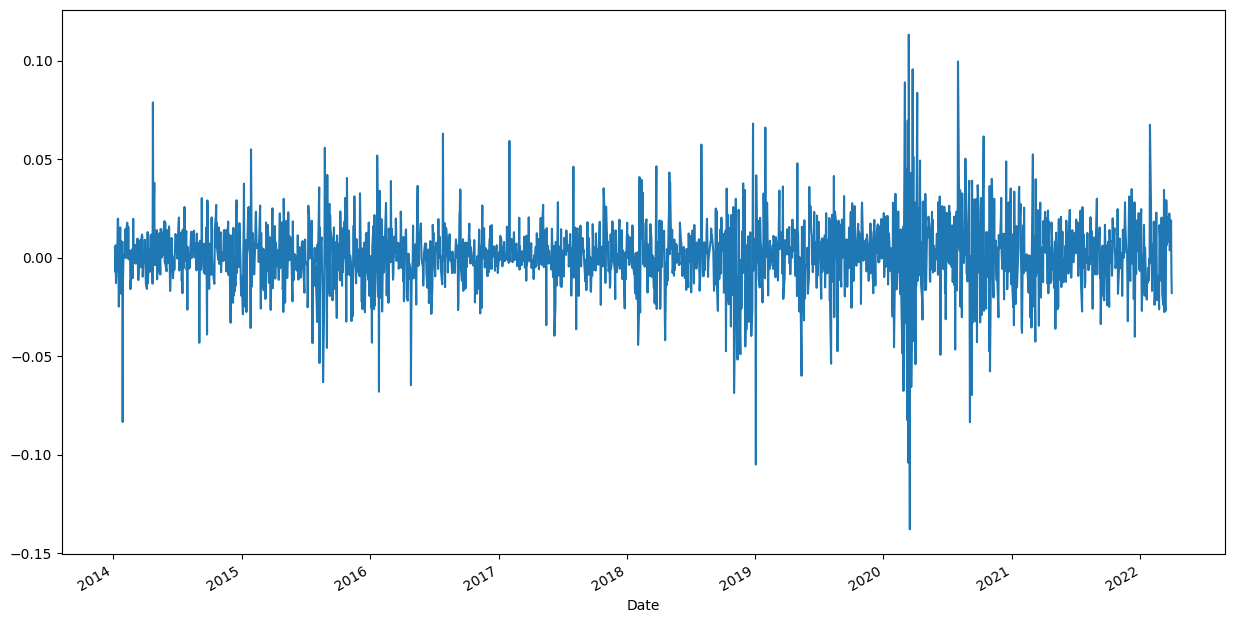

In [47]:
log_close_train = np.log(train_arima)
log_diff_1_close_train = log_close_train.diff().dropna()
log_diff_1_close_train.plot(figsize=(15,8))

In [48]:
stationarity_check(log_diff_1_close_train)

Test Statistic: -14.452585545256799
P-Value: 7.058339087327069e-27
Stationary


The log(Closing) price after one differencing is stationary with constant mean and variance so the next step we tune the arima_orders and train the ARIMA model.\
Up to now we have found the parameter "d", which is the number of times that differencing has been applied, to be 1. We then need to figure out the number of past values p and number of forecasted errors q to include. \
A useful tool is the ACF plot and PACF plot. ACF stands for autocorrelation function, ACF plots visualizes correlation of time series with its lags. e.g.:
y_t with y_t-k for k =1,2,3,...\
PACF stands for partial autocorrelation function, PACF plots visualizes the
 partial correlation of time series with its lags, after removing the effects of all lower order lag terms. e.g.: partial correlation of y_t and y_t-k is the correlation that is not explained by their relationships with the lags y_t-1,y_t-2,...,y_t-k+1.

In [49]:
def pacf(col):
    '''
    Plots the Partial Autocorrelation Function (PACF) of a given column.

    Parameters:
    col: The time series data for which the PACF plot is to be generated.

    Returns:
    It plots the time series data and its PACF.

    The function creates a two-panel plot:
    - The first panel shows the original time series data.
    - The second panel shows the PACF of the time series data using the Yule-Walker method.
    '''

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_pacf(col, method='ywm', ax=ax2);


def acf(col):
    '''
    Plots the Autocorrelation Function (ACF) of a given column.

    Parameters:
    col: The time series data for which the ACF plot is to be generated.

    Returns:
    It plots the time series data and its ACF.

    The function creates a two-panel plot:
    - The first panel shows the original time series data.
    - The second panel shows the ACF of the time series data.

    '''
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_acf(col, ax=ax2);

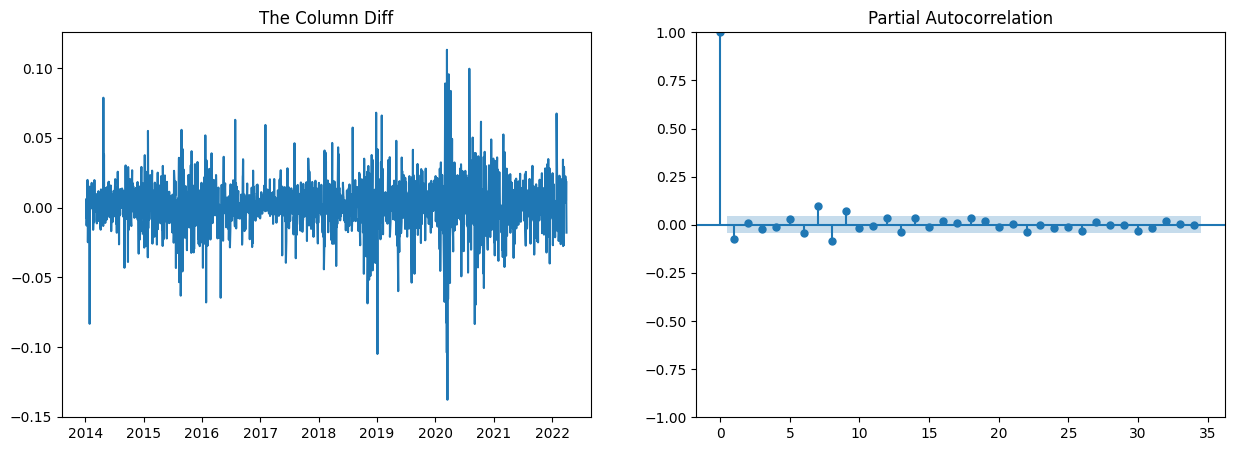

In [50]:
pacf(log_diff_1_close_train)

From the PACF graph, we see that the first,and 7th lags are significant. This suggests two choices of q: 1 and 7.

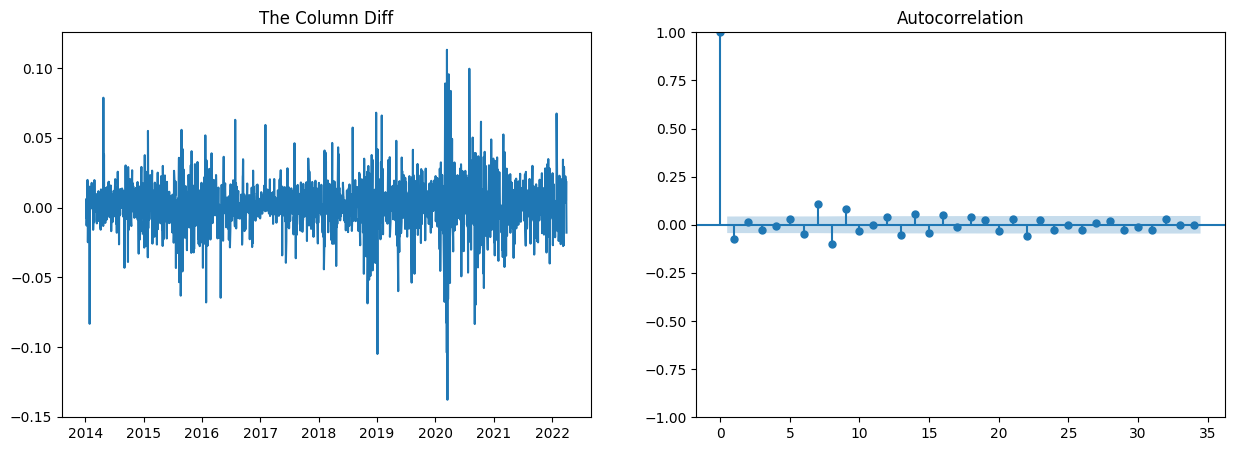

In [51]:
acf(log_diff_1_close_train)

Similary, the ACF plot suggests significant lags at lag 1,and lag 7, and lag 9.This suggests a few choices for p:1,7,9.


To confirm our choices of p,d,q, let's use auto-arima model to find the best parameters in a grid-search way.

In [52]:
#Define auto-arima to find best model
auto_arima_model = pm.auto_arima(log_close_train,
                      d = 1,
                      start_p = 0,
                      max_p = 9,
                      start_q = 0,
                      max_q = 7,
                      stepwise=False,
                      max_order=30,
                      trace=True)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-10821.920, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-10831.621, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-10829.915, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-10829.499, Time=0.71 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-10827.498, Time=0.45 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-10826.252, Time=1.34 sec
 ARIMA(0,1,6)(0,0,0)[1] intercept   : AIC=-10824.971, Time=0.23 sec
 ARIMA(0,1,7)(0,0,0)[1] intercept   : AIC=-10839.072, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-10831.884, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-10830.285, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-10827.717, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-10827.509, Time=0.78 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-10825.517, Time=1.35 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=-10840.531, Time=1.01 sec
 ARIMA(1,1,6)(0,0,0)[1] intercept   : AIC=-10840

In [53]:
auto_arima_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 6),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 1),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

After running the auto_arima model, we got the best (p,d,q) orders. Let us use this order as parameter for classic ARIMA and fit our log(Closing Price).

C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\65732\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\

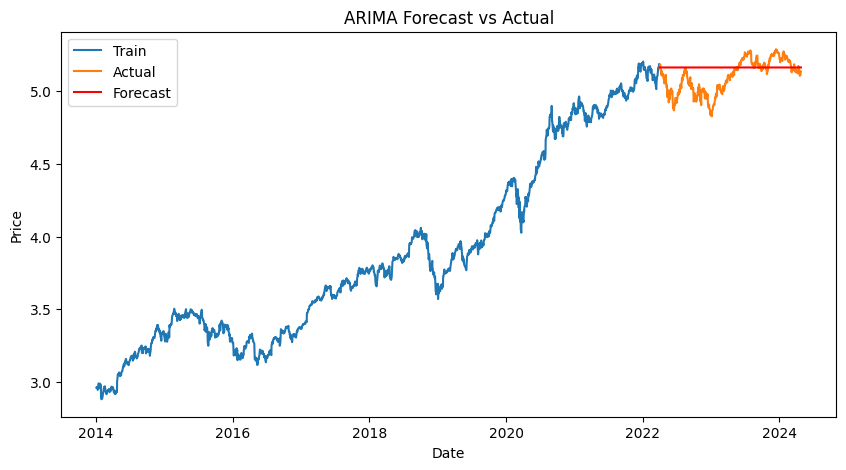

In [54]:
#create an instance of the model
model_arima = ARIMA(log_close_train, order=(1,1,1))
model_arima_fit = model_arima.fit()
log_test_arima = np.log(test_arima)

# Forecasting
forecast = model_arima_fit.forecast(steps=len(test_arima))
plt.figure(figsize=(10,5))
plt.plot(train_arima.index, log_close_train, label='Train')
plt.plot(test_arima.index, log_test_arima, label='Actual')
plt.plot(test_arima.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [55]:
print(forecast)

2076    5.163632
2077    5.163293
2078    5.163400
2079    5.163366
2080    5.163377
          ...   
2590    5.163374
2591    5.163374
2592    5.163374
2593    5.163374
2594    5.163374
Name: predicted_mean, Length: 519, dtype: float64


Based on the forcast result, it rapidly converge to a constant value and failed to accommdate the acutal pattern, the model was not ideal for the time series data.

In [56]:
rmse_arima = np.sqrt(mean_squared_error(log_test_arima ,forecast))
mae_arima = mean_absolute_error(log_test_arima,forecast)
print('Root Mean Squared Error: ', rmse_arima)
print('Mean Absolute Error: ', mae_arima)

Root Mean Squared Error:  0.12831691577161006
Mean Absolute Error:  0.10141358401907899


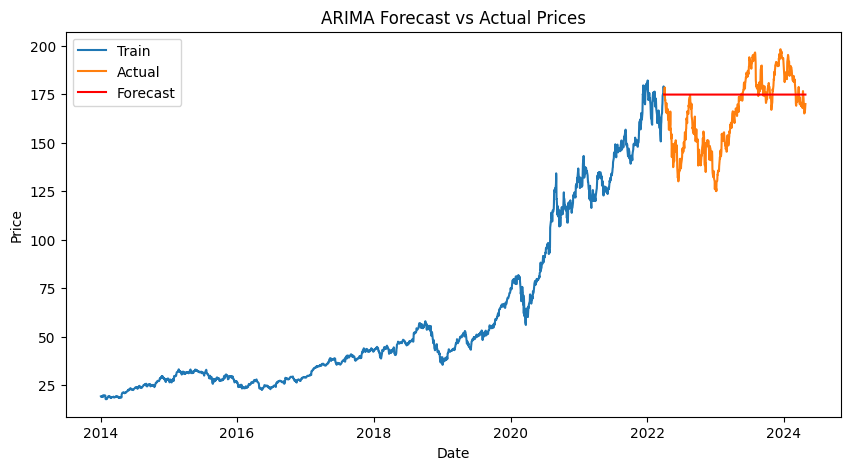

In [57]:
actual_prices = np.exp(log_test_arima)
predicted_prices = np.exp(forecast)
plt.figure(figsize=(10,5))
plt.plot(train_arima.index, np.exp(log_close_train), label='Train')
plt.plot(test_arima.index, actual_prices, label='Actual')
plt.plot(test_arima.index, predicted_prices, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [58]:
rmse_original = np.sqrt(mean_squared_error(actual_prices ,predicted_prices))
mae_original = mean_absolute_error(actual_prices,predicted_prices)
print('Root Mean Squared Error: ', rmse_original)
print('Mean Absolute Error: ', mae_original)

Root Mean Squared Error:  20.570370115849418
Mean Absolute Error:  16.65747748668604


We see that the forecasts converges quuicly to the mean, giving undesirbale results. This could be due to the nature of the ARIMA model: ARIMA seems incapable of predicting long term patterns or capturing the turining points.However, as stock price prediction is a difficult task involving market sentiment, government policies, corporate actions and global events, therefore it is not surprising that linear model like the ARIMA models find it difficult to internalize all these factors and make accurate predictions.

## 4. Discussion

Our project aimed to evaluate deep learning models in the scenario of predicting stock prices. We selected Apple Inc.'s stock price (NASDAQ: APPL) as our subject of investigation, using deep learning models to predict its stock price.

We inspected Apple's stock price in the past ten years and analyzed its patterns. Observations indicate that preceding prices and trends are informative of future prices and trends. Plus, in comparison, we derived common finance indicators of stock price prediction, like MACD, to which our model is expected to serve as a superior alternative.

#### 4.1 Comparison of Model Performance

By leveraging historical stock price data, we train two neural network models (Basic NN and CNN), RNN, and three time-series RNN models, evaluating their predictive accruacy.

In [59]:
lstm_val_loss = history_lstm.history['val_loss']
cnn_val_loss = history_cnn.history['val_loss']
rnn_val_loss = history_rnn.history['val_loss']
gru_val_loss = history_gru.history['val_loss']
nn_reg_val_loss=nn_reg_history.history['val_loss']
nn_val_loss=nn_history.history['val_loss']


Upon first-step investigation, we noticed the rather suboptimal performance of the ARIMA model. We thus eliminated it in further procedures of comparison. (See detailed explanation in part 3.6.)

We visualize the validation losses of the rest of the models as a side-by-side boxplot seen below, measuring the predictions with respect to unseen data. To ensure the losses reflect the model performances when they are mature rather than not fully trained, we compare the validation loss distribution of only the last 50 epochs for each model.

C:\Users\65732\AppData\Local\Temp\ipykernel_4600\4294019474.py:14: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



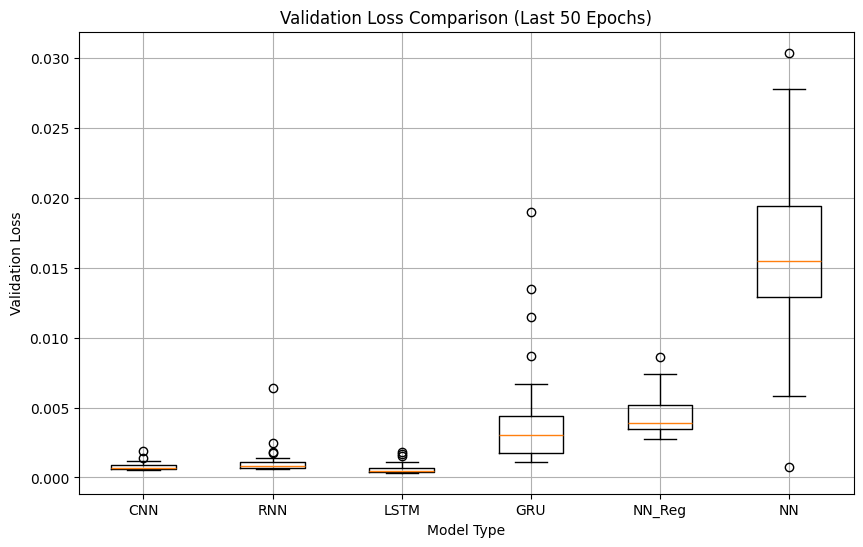

In [60]:
# Subsetting the last 50 epochs
cnn_val_loss_last_50 = cnn_val_loss[-50:]
rnn_val_loss_last_50 = rnn_val_loss[-50:]
gru_val_loss_last_50 = gru_val_loss[-50:]
nn_reg_val_loss_last_50 = nn_reg_val_loss[-50:]
nn_val_loss_last_50 = nn_val_loss[-50:]
lstm_val_loss_last_50 = lstm_val_loss[-50:]

# Combining the data into a list for the last 50 epochs
data_last_50 = [cnn_val_loss_last_50, rnn_val_loss_last_50,lstm_val_loss_last_50 ,gru_val_loss_last_50, nn_reg_val_loss_last_50, nn_val_loss_last_50 ]

# Creating the box plot for the last 50 epochs
plt.figure(figsize=(10, 6))
plt.boxplot(data_last_50, labels=['CNN', 'RNN', 'LSTM', 'GRU', 'NN_Reg', 'NN'])
plt.title('Validation Loss Comparison (Last 50 Epochs)')
plt.ylabel('Validation Loss')
plt.xlabel('Model Type')
plt.grid(True)
plt.show()

The performance of unregularized nerual network is notably inferior to the other five models. We now move on to compare their performance by looking at their MSEs.

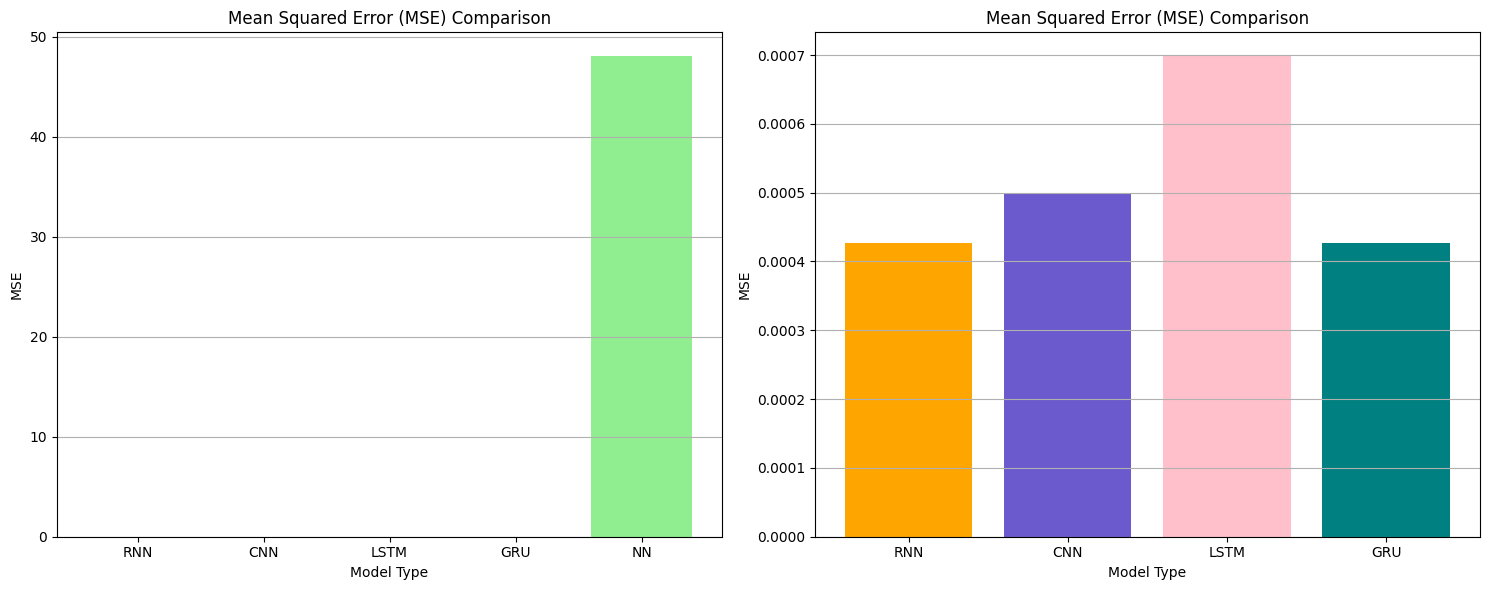

In [61]:
mse_values1 = {
    'RNN': test_mse_rnn,
    'CNN': test_mse_cnn,
    'LSTM': test_mse_lstm,
    'GRU': test_mse_gru,
}

mse_values2 = {
    'RNN': test_mse_rnn,
    'CNN': test_mse_cnn,
    'LSTM': test_mse_lstm,
    'GRU': test_mse_gru,
    'NN': test_mse_nn
}

#creating the subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First plot
axs[1].bar(mse_values1.keys(), mse_values1.values(), color=['orange', 'slateblue', 'pink', 'teal'])
axs[1].set_title('Mean Squared Error (MSE) Comparison')
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('Model Type')
axs[1].grid(axis='y')

# Second plot
axs[0].bar(mse_values2.keys(), mse_values2.values(), color=['orange', 'slateblue', 'pink', 'teal', 'lightgreen'])
axs[0].set_title('Mean Squared Error (MSE) Comparison')
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('Model Type')
axs[0].grid(axis='y')

# Display the subplots
plt.tight_layout()
plt.show()

From the above,  the performance of CNN, RNN, LSTM, and GRU models are stronger than regularized FeedForward Neural Network with much smaller MSEs. Considering that all models are tuned with optimizing hyperparameters, we have grounds to believe that RNN, GRU, CNN, and LSTM are all preferrable models for stock price prediction. Comparing the four prediction line plots, we observe that the LSTM and GRU are better at predicting intricate patterns with occasional spikes and plummets, which RNN and CNN tend to iron out.

### 4.2 Limitations

1. Overfitting

For the four model of preferable performances (RNN, CNN, LSTM, GRU), we noticed a common indication of minor overfitting with test MSE being 2-3 times larger than the test MSE, in spite of our efforts to mitigate it. This could be a comprehensive result of the nature of the data and features of the model.

Financial data feature high noise levels caused by instantaneous events of all kinds. It is difficult for models to generalize sparse, rare events of impact into features with predictable patterns. Therefore, the trained models might underperform with test data.

Another underlying factor is that the models we employed and trained are rather complex with a lot of neurons and weights. In comparison, our dataset is rather small. This might add up to overfitting issues where some weights and neurons are held up to disproportionate significance.

In addition to our existing methods to mitigate overfitting, we could also have smoothed or denoised the training data so that the models would learn less noises and be more on-target in its predictions.

2. Limited time step

Due to the limitation of computational resources and sample size, we select relatively small numbers of time_steps (amount) of data from the training set, instead of the entire training set, as input to predict the next output. For stocks which usually feature yearly seasonality, it would be more logically solid to feed in data of a longer time span as input for prediction. We also infer that the prediction performance would be enhanced with larger input sizes.

Plus, since the input data for each value of prediction are from the training set (which means that they are real values), our models cannot provide a preview of trends across a time period in the future - it looks only one step ahead.

3. The future is unpredictable

Models in our project make prediction about a future stock price based on the previous behaviors of this stock. However, in real life, the behavior of every stock is constantly evolving subject to unpredictable events. Thus, there is always a degree of uncertainty which deep learning models cannot account for, and they should not bear full reliance when it comes to real life trading decision-making.

### 4.3 Implications

Technically, our project effectively explores the usage and performance of various kinds of deep learning models in the scenario of stock price prediction.
We find that:

1) Suitable models (like in our case, CNN, RNN, LSTM and GRU) can capture most patterns of the real data values when appropriately tuned; however, they struggle to predict the sudden spikes and plummets to the full extent, losing grip of the details.

2) It is difficult to completely eliminate overfitting given the features of the data and models.

Our findings, along with our data preprocessing and hyperparamter tuning procedures, provide reference for other value prediction tasks dealing with time-series data similar to stock prices. Inquisitive individuals can build up from our model to further explore the characteristics of the models we touched on.

As of practical appilcations, although we find deep learning model alone to be insufficient as a guide for trading decisions in real life, appropriate models can still provide an "educated guess" for those who are interested.

In future work, it would be beneficial to explore denoising techniques and other feature engineering methods to smooth the data. These approaches could help build models that generalize better to unseen data, potentially improving their predictive ability and robustness. Furthermore,it could be rewarding to try incorporating more factors such as social media sentiment, economic reports and potentially develop more resilient predictive models that enhance the ability to adapt to market changes that will better meet the needs and deliver a fully accurate and reliable prediction.
